# Beginners Notes on Exponential Smoothing with NumPyro

This notebook serves as personal notes on [`NumPyro`](
https://num.pyro.ai/en/stable/index.html)'s implementation of the classic [exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) forecasting method. I use (https://num.pyro.ai/en/stable/examples/holt_winters.html). The strategy is to go into the nitty-gritty details of the code presented in the example from the documentation: ["Example: Holt-Winters Exponential Smoothing"](https://num.pyro.ai/en/stable/examples/holt_winters.html). In particular, I want to understand the auto-regressive components using the [`scan`](https://num.pyro.ai/en/stable/primitives.html#scan) function, which always confuses me 😅. After reproducing the example from the documentation, we go a step further and extend the algorithm to include a damped trend.

These notes do not aim to give a complete introduction to exponential smoothing. Instead, we focus on the implementation using NumPyro. For a detailed and comprehensive introduction to the subject (and forecasting topics in general), please refer to the great online book ["Forecasting: Principles and Practice"](https://otexts.com/fpp3/) by Rob J Hyndman and George Athanasopoulos. In particular, see [Chapter 8](https://otexts.com/fpp3/expsmooth.html) for an introduction to exponential smoothing.

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import random
from jax.lax import fori_loop
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## The Scan Function

We start these notes by revisiting the [`scan`](https://num.pyro.ai/en/stable/primitives.html#scan) function as it is a key ingredient in the implementation of the exponential smoothing algorithm. The `scan` function is a generalization of the `for` loop. It is used to perform a computation that depends on the previous step's output. This operator uses [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) to allow NumpPyro primitives like [`sample`](https://num.pyro.ai/en/stable/primitives.html?highlight=scan#sample) and [`deterministic`](https://num.pyro.ai/en/stable/primitives.html?highlight=scan#deterministic) to be used in a loop. The `scan` function is used to implement the auto-regressive components of the exponential smoothing algorithm. To gain some intuition about this function, the [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) documentation provides a rough pure Pyhton implementation of the `scan` function:

```python
def scan(f, init, xs, length=None):
  """Pure Python implementation of scan.

  Parameters
  ----------
  f : A  a Python function to be scanned.
  init : An initial loop carry value
  xs : The value over which to scan along the leading axis.
  length :  Optional integer specifying the number of loop iterations,
      which must agree with the sizes of leading axes of the arrays in
      xs (but can be used to perform scans where no input xs are needed).
  """
  if xs is None:
    xs = [None] * length
  carry = init
  ys = []
  for x in xs:
    carry, y = f(carry, x)
    ys.append(y)
  return carry, np.stack(ys)
```

Whenever I read this I get a bit confused. So let's try to understand the `scan` function by implementing a simple example. 

### Example: Sum of Powers

We will implement a simple sum of powers. We want to calculate the sum of the first `h` powers of a number `phi`. 

$$
\phi \longmapsto \phi^1 + \phi^2 + \ldots + \phi^h
$$

We can do this using a `for` loop. However, we want to use the `scan` function to get a better understanding of how it works.

First, we implement the sum of powers using a `for` loop.

In [2]:
def sum_of_powers_for_loop(phi: float, h: int) -> float:
    return sum(phi**i for i in range(1, h + 1))


assert sum_of_powers_for_loop(2, 0) == 0
assert sum_of_powers_for_loop(2, 1) == 2
assert sum_of_powers_for_loop(2, 2) == 2 + 2**2
assert sum_of_powers_for_loop(2, 3) == 2 + 2**2 + 2**3

Now, let's look at the implementation using the `scan` function.

In [3]:
def sum_of_powers_scan(phi, h):
    def transition_fn(carry, phi):
        power_sum, power = carry
        power = power * phi
        power_sum = power_sum + power
        return (power_sum, power), power_sum

    (power_sum, _), _ = scan(f=transition_fn, init=(0, 1), xs=jnp.ones(h) * phi)
    return power_sum

We can verify that the two implementations give the same result.

In [4]:
assert sum_of_powers_scan(2, 0) == sum_of_powers_for_loop(2, 0)
assert sum_of_powers_scan(2, 1) == sum_of_powers_for_loop(2, 1)
assert sum_of_powers_scan(2, 2) == sum_of_powers_for_loop(2, 2)
assert sum_of_powers_scan(2, 3) == sum_of_powers_for_loop(2, 3)
assert sum_of_powers_scan(2, 10) == sum_of_powers_for_loop(2, 10)

There is another handy function to write efficient for loops in JAX: the [`fori_loop`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html) function. From the documentation we also get a pure Python implementation:

```python
def fori_loop(lower, upper, body_fun, init_val):
  val = init_val
  for i in range(lower, upper):
    val = body_fun(i, val)
  return val
```

In this case we can easily implement the sum of powers using the `fori_loop` function.

In [5]:
def sum_of_powers_fori_loop(phi, h):
    def body_fn(i, power_sum):
        return power_sum + phi**i

    return fori_loop(lower=1, upper=h + 1, body_fun=body_fn, init_val=0)

In [6]:
assert sum_of_powers_scan(2, 0) == sum_of_powers_for_loop(2, 0)
assert sum_of_powers_scan(2, 1) == sum_of_powers_for_loop(2, 1)
assert sum_of_powers_scan(2, 2) == sum_of_powers_for_loop(2, 2)
assert sum_of_powers_scan(2, 3) == sum_of_powers_for_loop(2, 3)
assert sum_of_powers_scan(2, 10) == sum_of_powers_for_loop(2, 10)

After this brief introduction to the `scan` function, we are ready to dive into the implementation of the exponential smoothing algorithm using NumPyro.

## Generate Synthetic Data

We start by generating some synthetic data. We will use a very similar data generation process as in the example from the documentation. We generate a time series with a trend and a seasonal component.

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

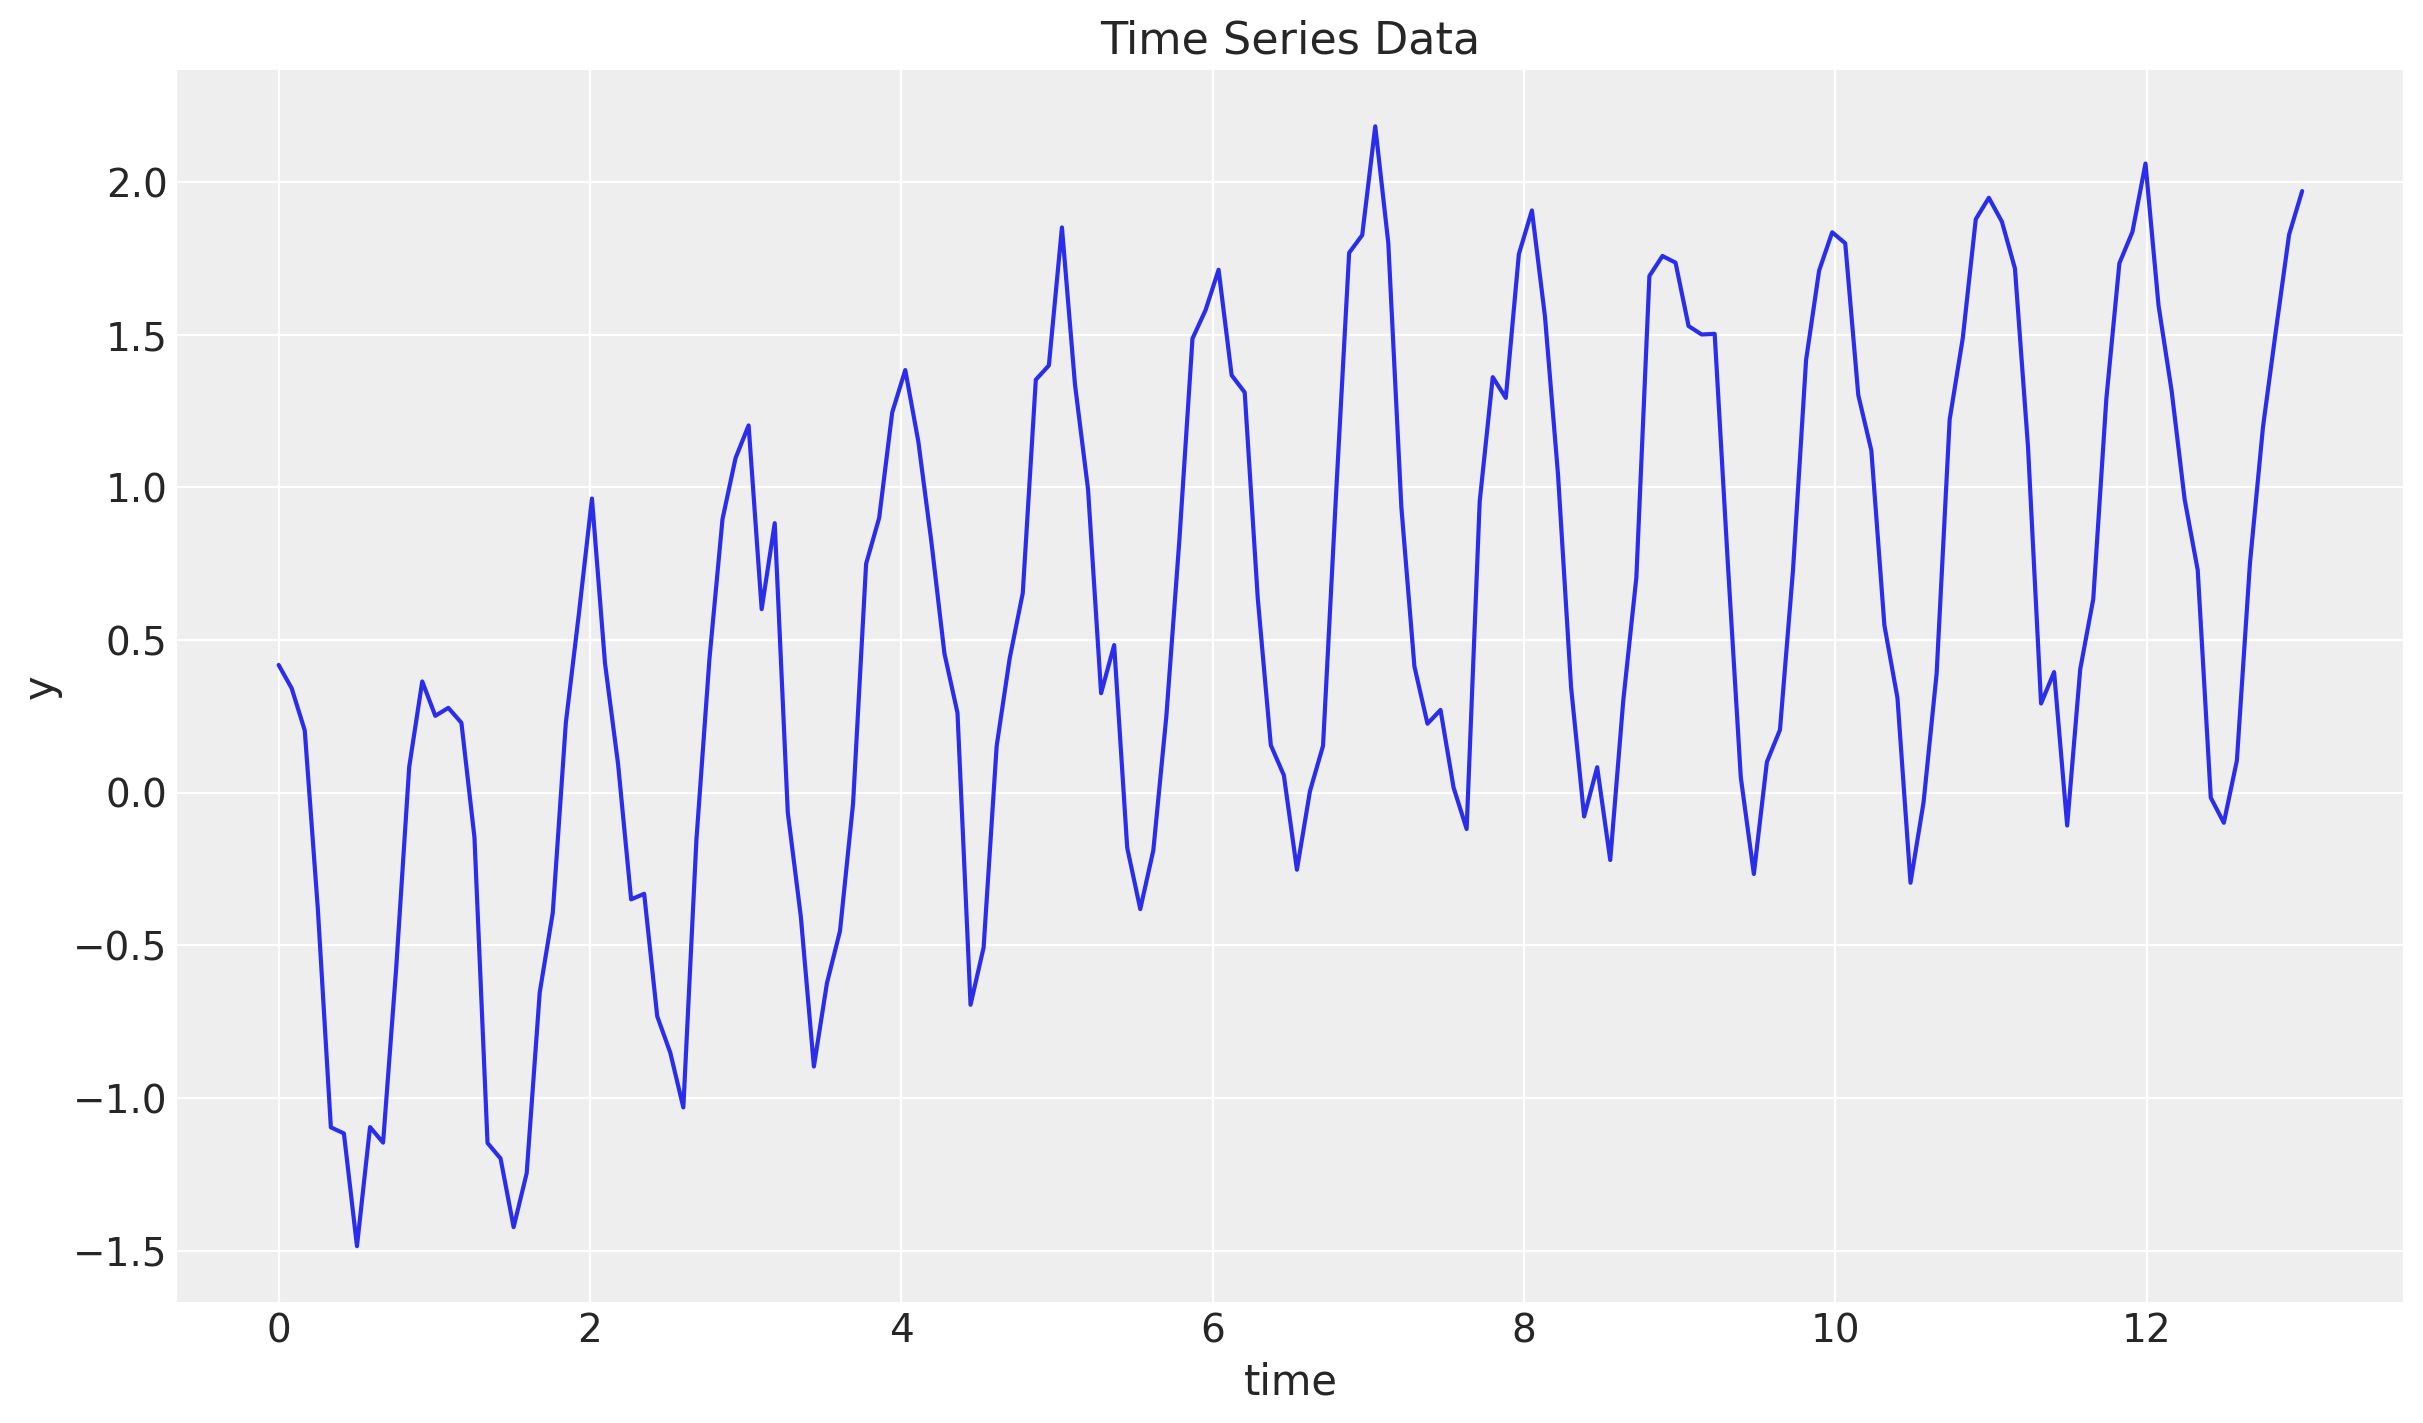

In [7]:
n_seasons = 12
t = jnp.linspace(start=0, stop=n_seasons + 1, num=(n_seasons + 1) * n_seasons)
y = (
    jnp.cos(2 * jnp.pi * t)
    + jnp.log(t**2 + 2)
    - 1.1 * jnp.sqrt(t + 1)
    + 0.2 * random.normal(rng_key, t.shape)
)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

## Train - Test Split

We now split the data into a training and a test set. We will use the training set to fit the model and the test set to evaluate the model's performance.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

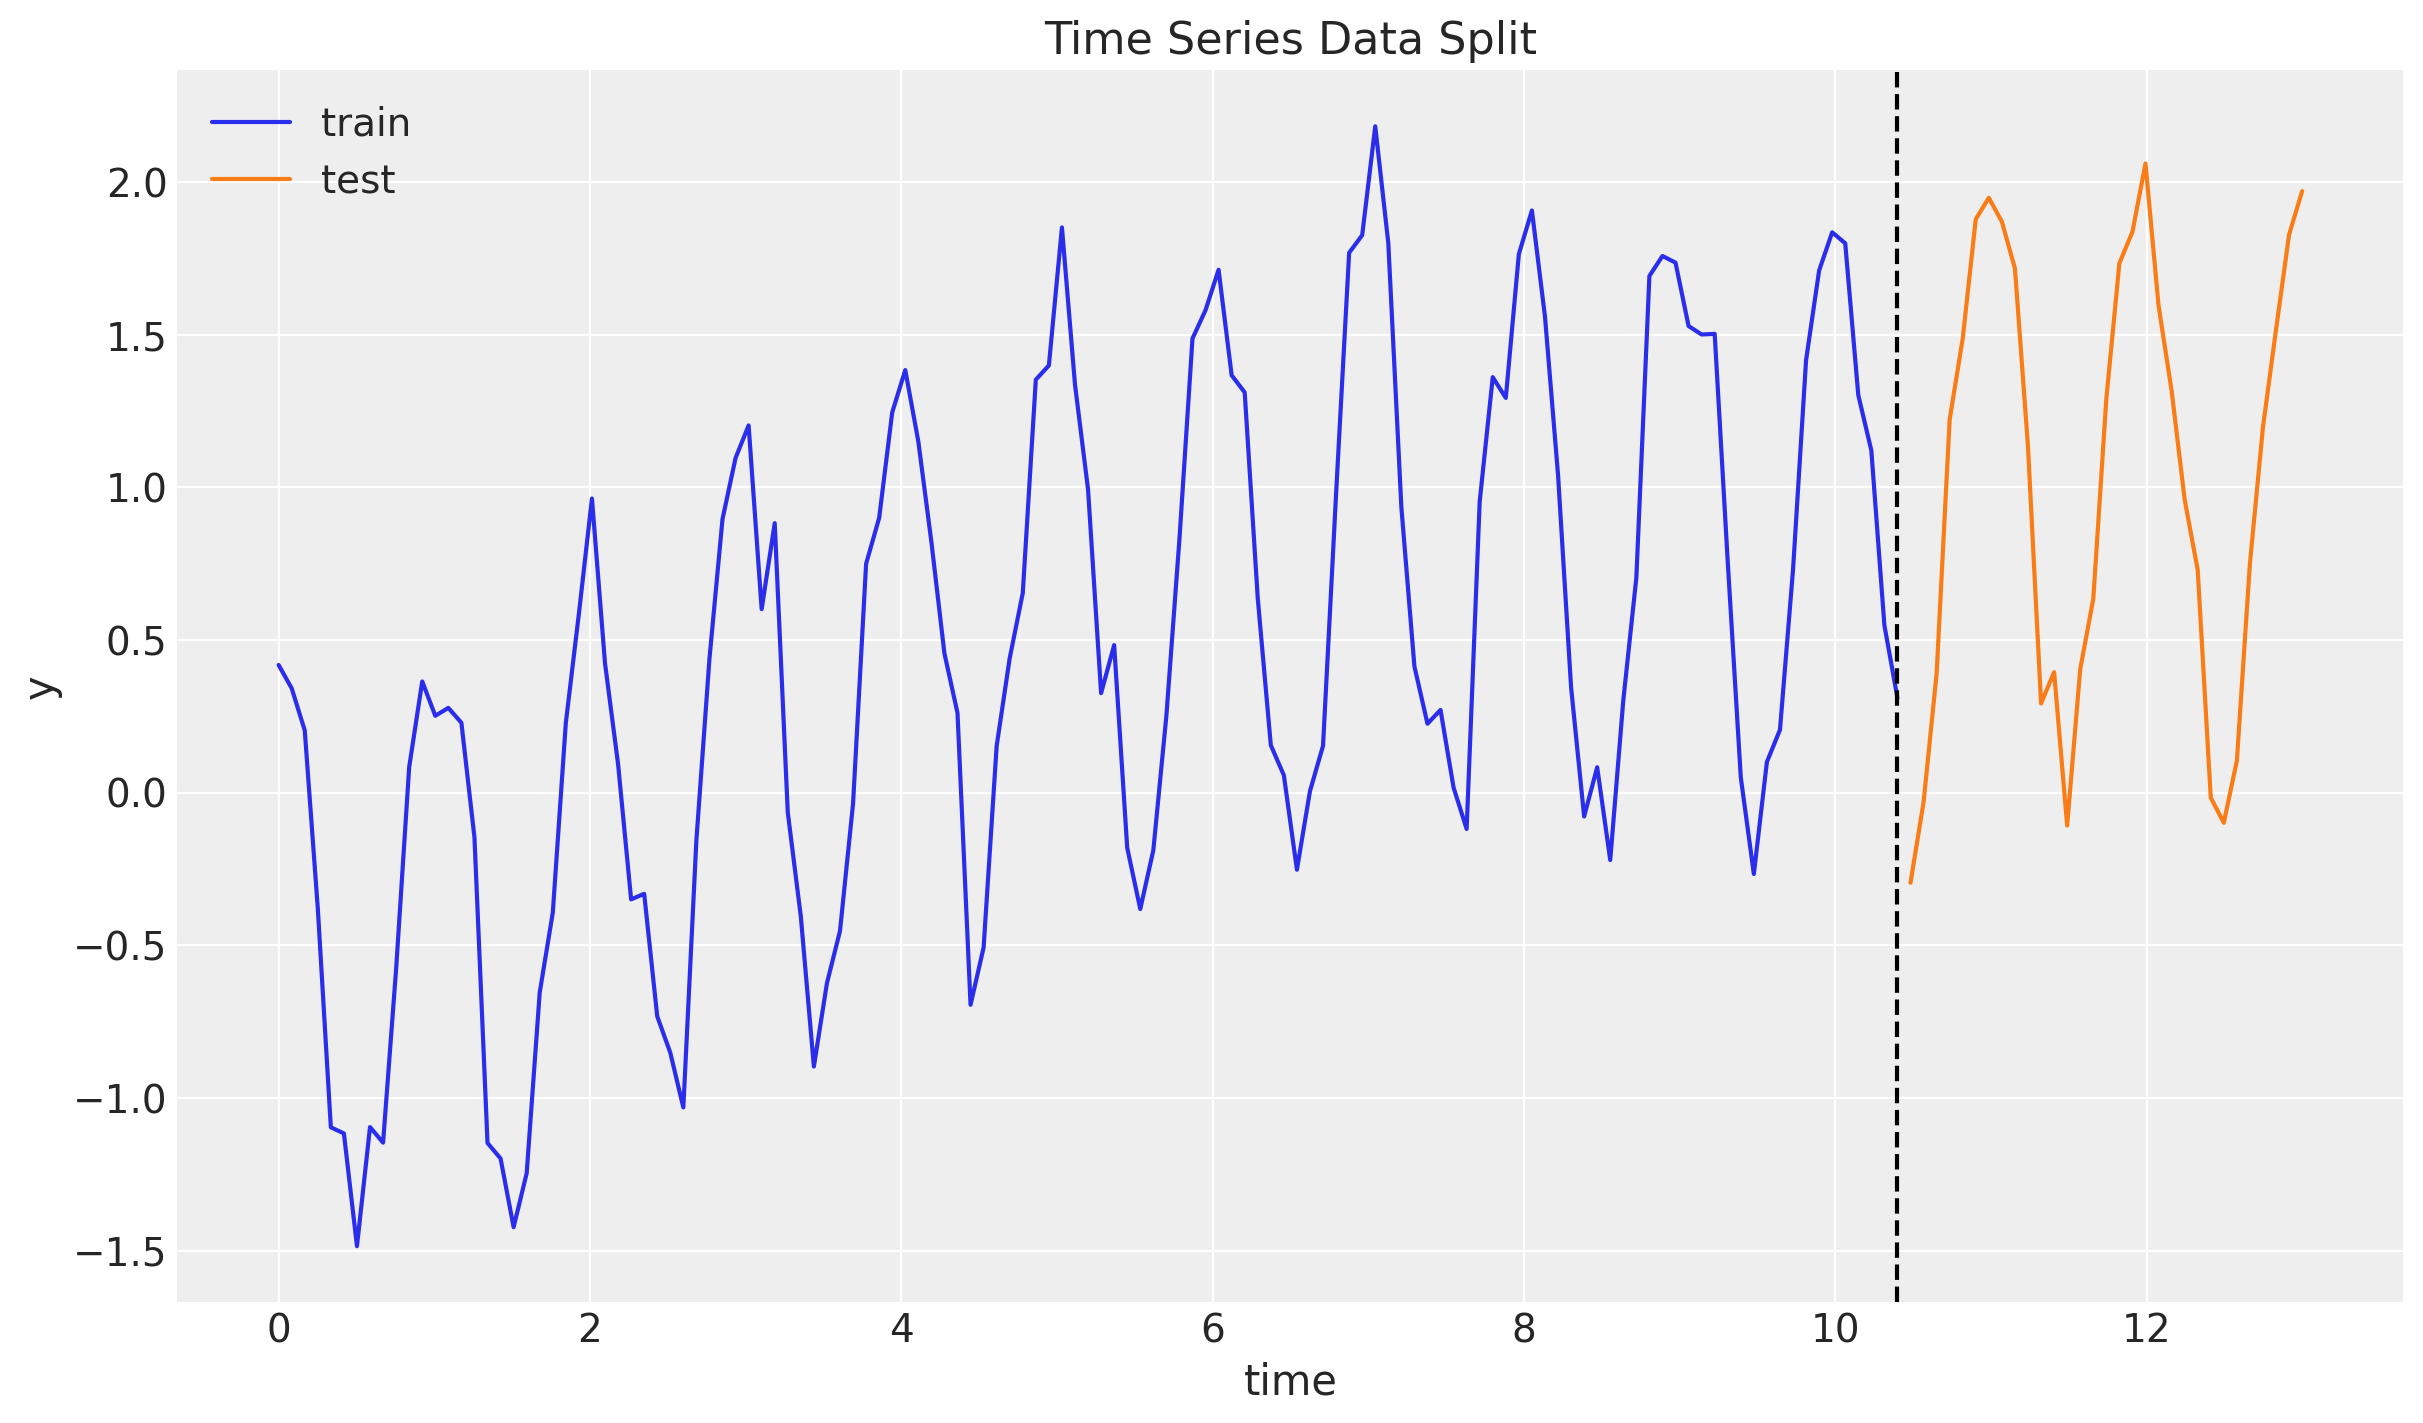

In [8]:
n = y.size

prop_train = 0.8
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## Level Model

We do not look and the complete model from start. Instead, we progressively study and add components. We start with the most fundamental component of the model: the level model. The level model is a simple model that predicts the next value in the time series based on the previous value. The model is defined by the following equations:

\begin{align*}
\hat{y}_{t+h|t} = & \: l_t \\
l_t = & \: \alpha y_t + (1 - \alpha)l_{t-1}
\end{align*}

Here:

- $y_t$ is the observed value at time $t$.
- $\hat{y}_{t+h|t}$ is the forecast of the value at time $t+h$ given the information up to time $t$.
- $l_t$ is the level at time $t$.
- $\alpha$ is the smoothing parameter. It is a value between 0 and 1. A value of 1 means that the forecast is based only on the observed value at time $t$. A value of 0 means that the forecast is based only on the previous level.

Note that the level equation is a simple weighted average of the observed value and the previous level (for more details see [8.1 Simple exponential smoothing](https://otexts.com/fpp3/ses.html)). Moreover, note that this equation is perfectly suited for the `scan` function.

### Model Specification

We start by specifying the level model in NumPyro. We use the same priors from the example in the documentation. Note that we place uniform priors on the smoothing parameter $\alpha$.

[Text(0.5, 1.0, 'Beta(1, 1) Prior')]

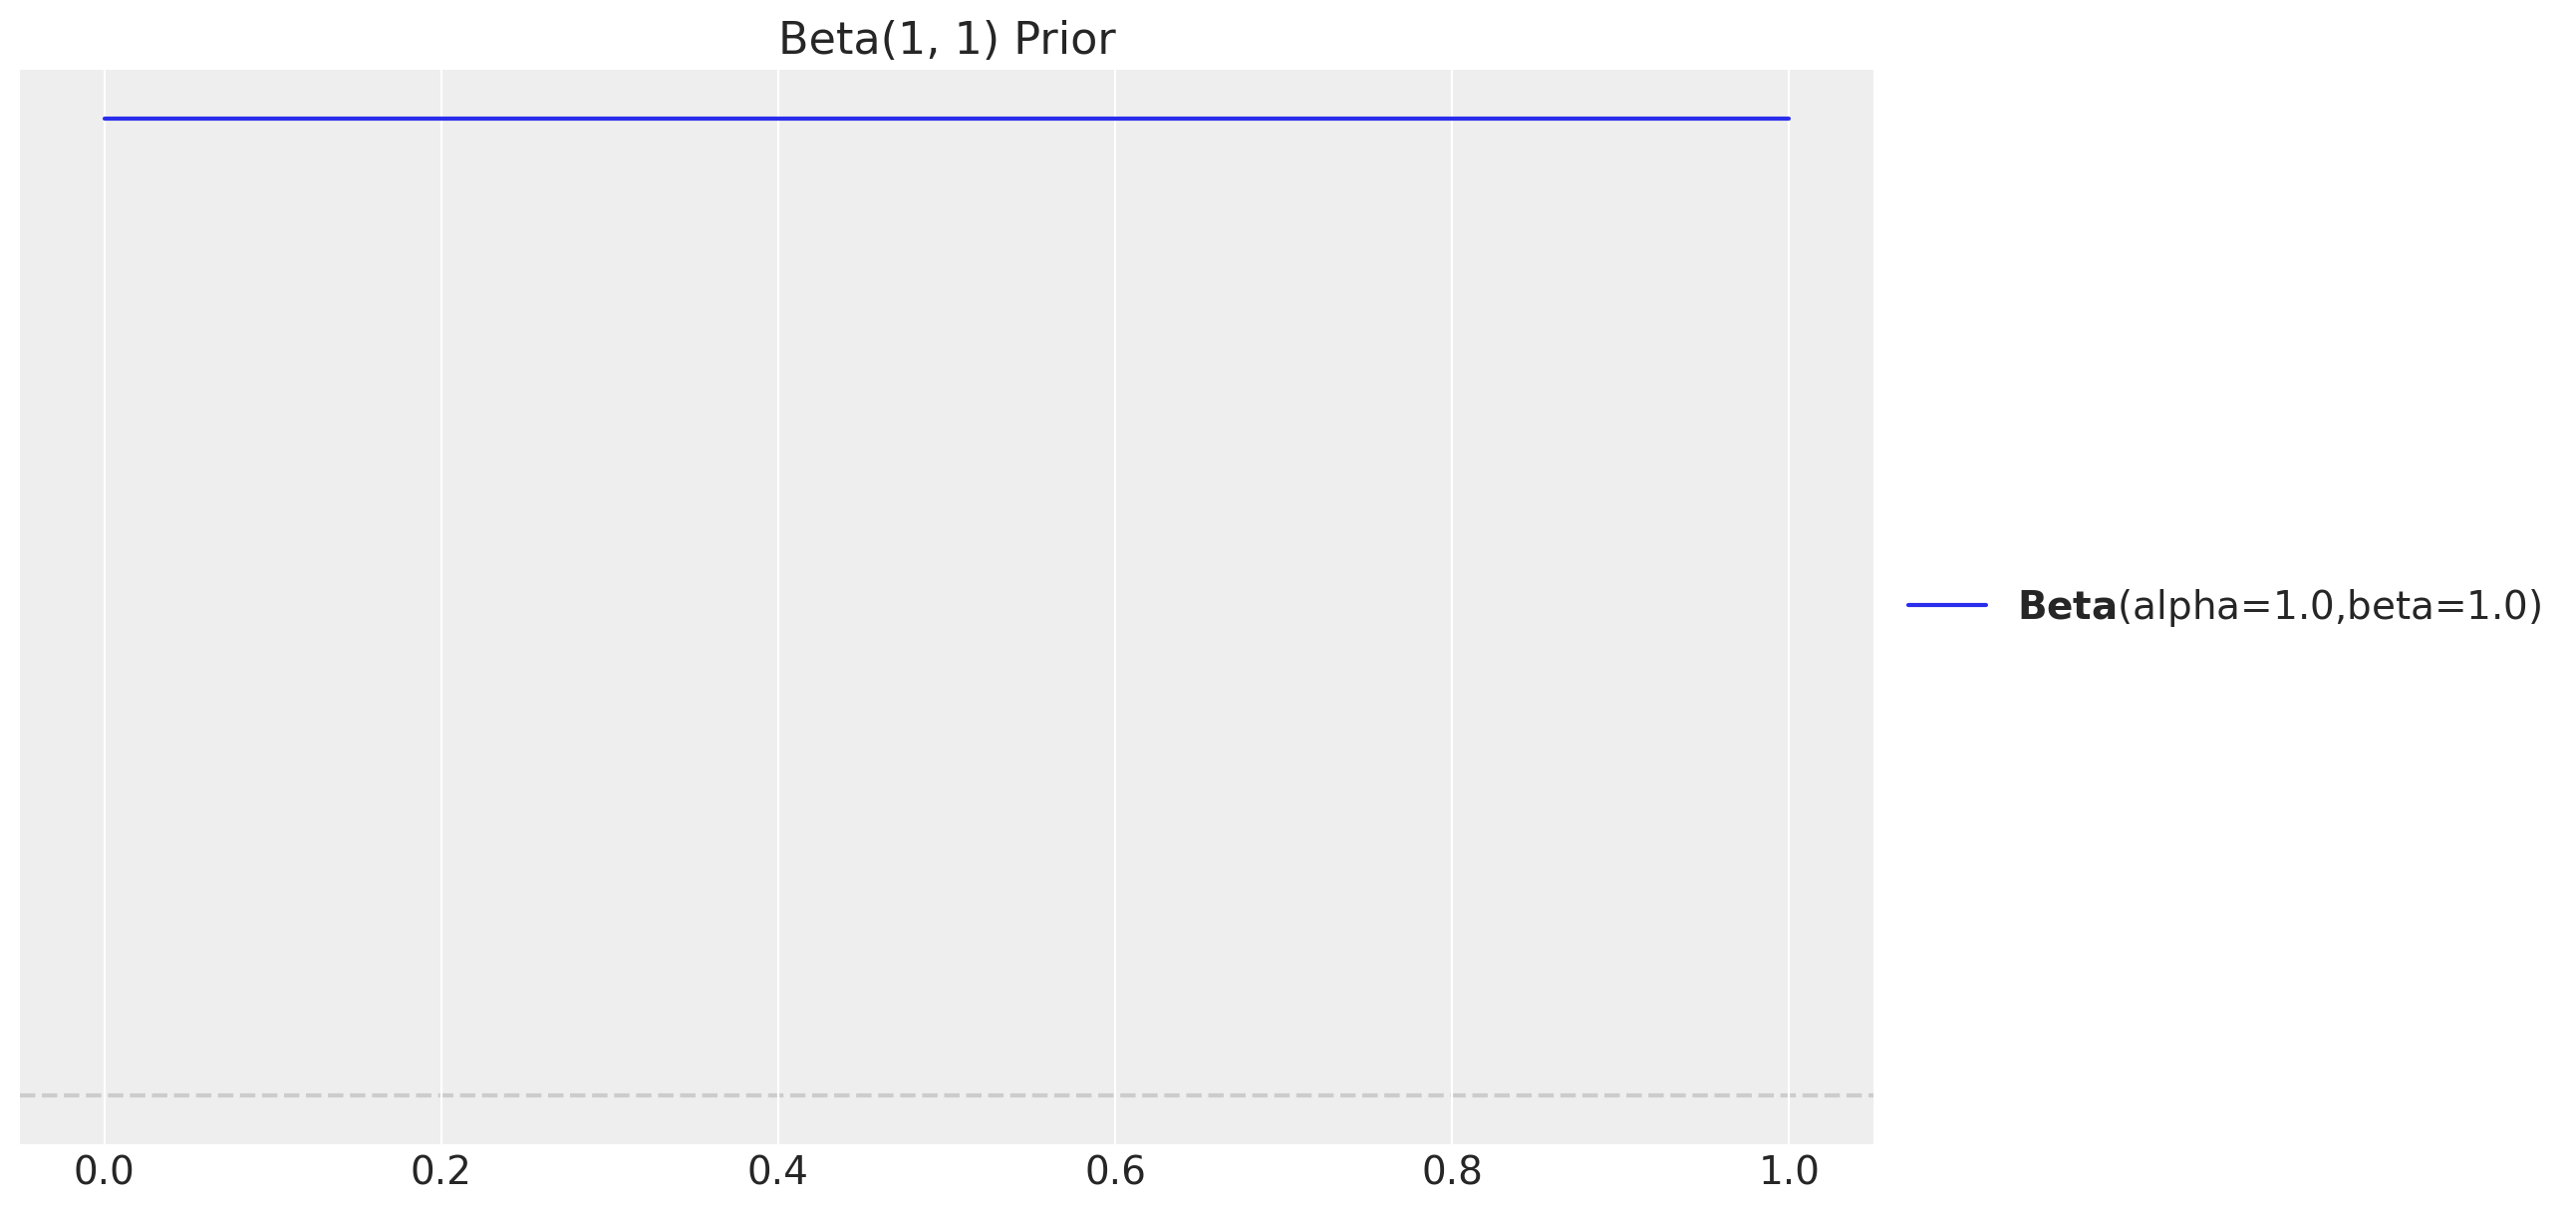

In [23]:
fig, ax = plt.subplots()
pz.Beta(alpha=1, beta=1).plot_pdf(ax=ax)
ax.set(title="Beta(1, 1) Prior")

In [9]:
def level_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t] + (1 - level_smoothing) * previous_level,
            previous_level,
        )

        mu = previous_level
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return level, pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            level_init,
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

Observe we are using the [`condition`](https://num.pyro.ai/en/stable/handlers.html#condition) effect handler to condition the model on the observed data. As explained in the example from the documentation ["Time Series Forecasting"](https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html):

> The reason is we also want to use this model for forecasting. In forecasting, future values of `y` are non-observable, so `obs=y[t]` does not make sense when `t >= len(y)` (**caution:** index out-of-bound errors do not get raised in JAX, e.g. j`np.arange(3)[10] == 2`). Using `condition`, when the length of `scan` is larger than the length of the conditioned/observed site, unobserved values will be sampled from the distribution of that site.

### Inference

We now proceed to use MCMC to fit the level model to the training data. We define some helper function as we will apply them to many models.

In [10]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

Let's fit the model:

In [11]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
level_mcmc = run_inference(rng_subkey, level_model, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

The diagnostics look good:

In [12]:
level_idata = az.from_numpyro(posterior=level_mcmc)

az.summary(data=level_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,0.348,0.412,-0.398,1.141,0.005,0.005,6212.0,5165.0,1.0
level_smoothing,0.982,0.017,0.951,1.000,0.000,0.000,5235.0,3247.0,1.0
noise,0.455,0.029,0.401,0.509,0.000,0.000,6719.0,5121.0,1.0


In [13]:
print(f"""Divergences: {level_idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Level Model Trace')

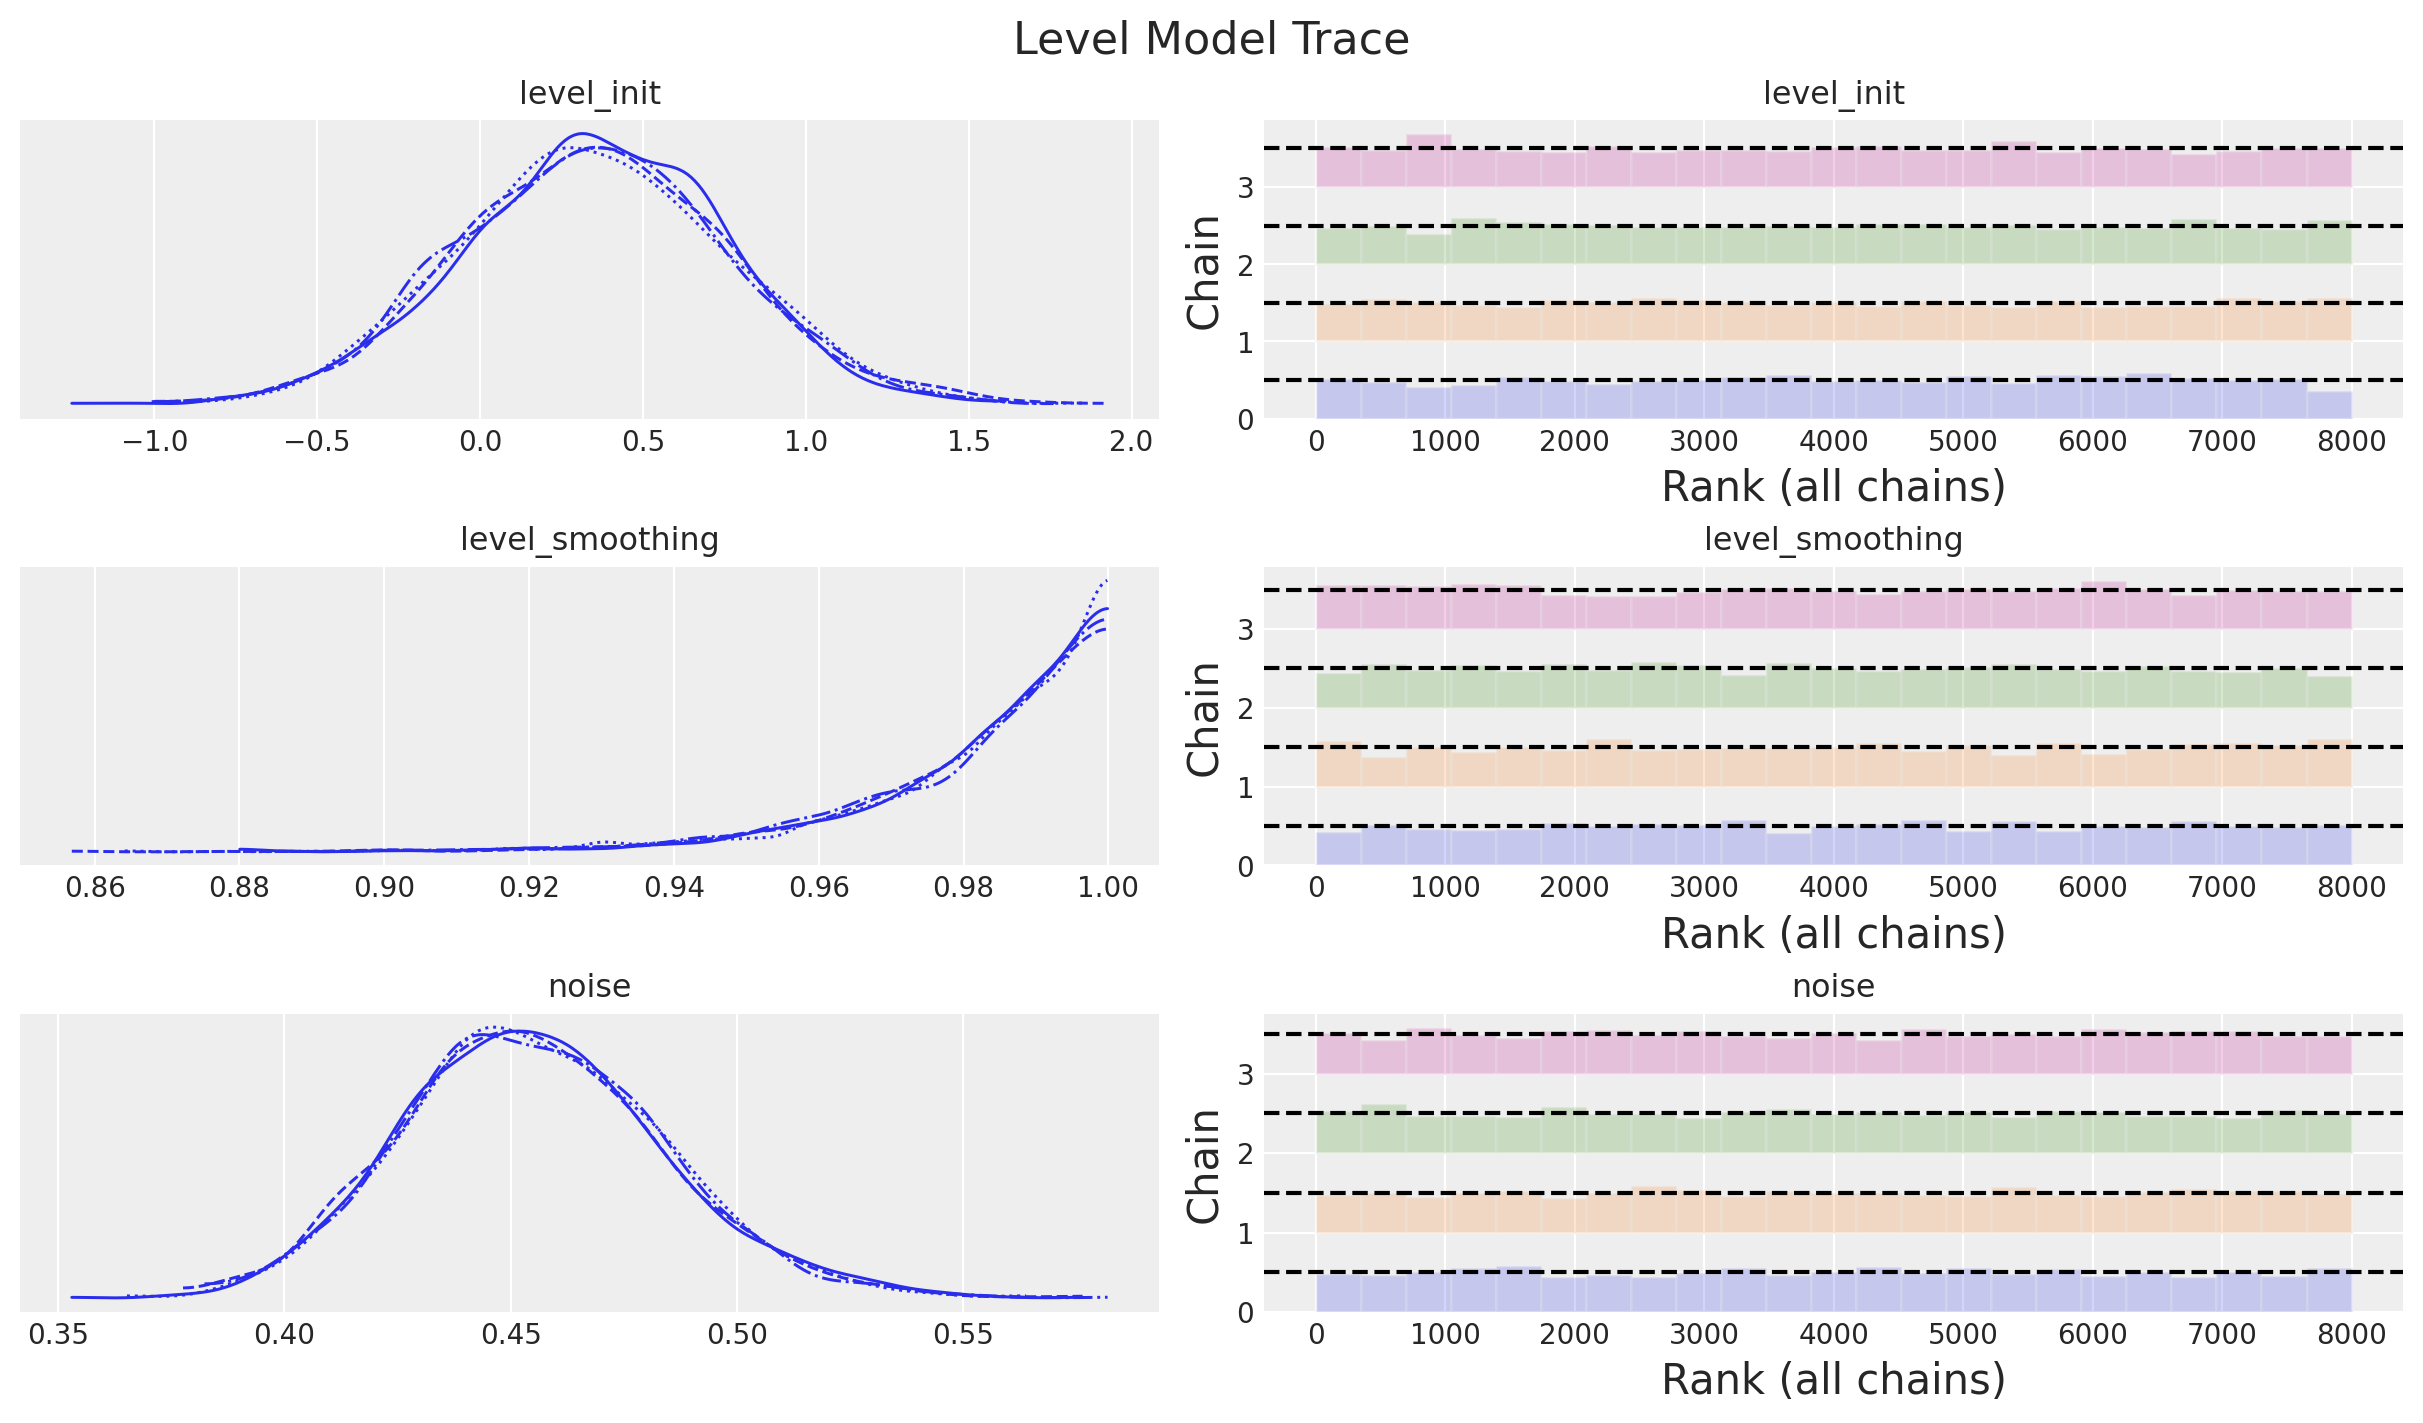

In [14]:
axes = az.plot_trace(
    data=level_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Level Model Trace", fontsize=16)

### Forecast

Now we can use the fitted model to forecast the test set. As above, we define a helper function for this purpose:

In [15]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast"],
    )
    return predictive(rng_key, *model_args)

In [16]:
rng_key, rng_subkey = random.split(key=rng_key)
level_forecast = forecast(
    rng_subkey, level_model, level_mcmc.get_samples(), y_train, y_test.size
)

In [17]:
level_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

We can now visualize the forecast:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level Model Forecast')]

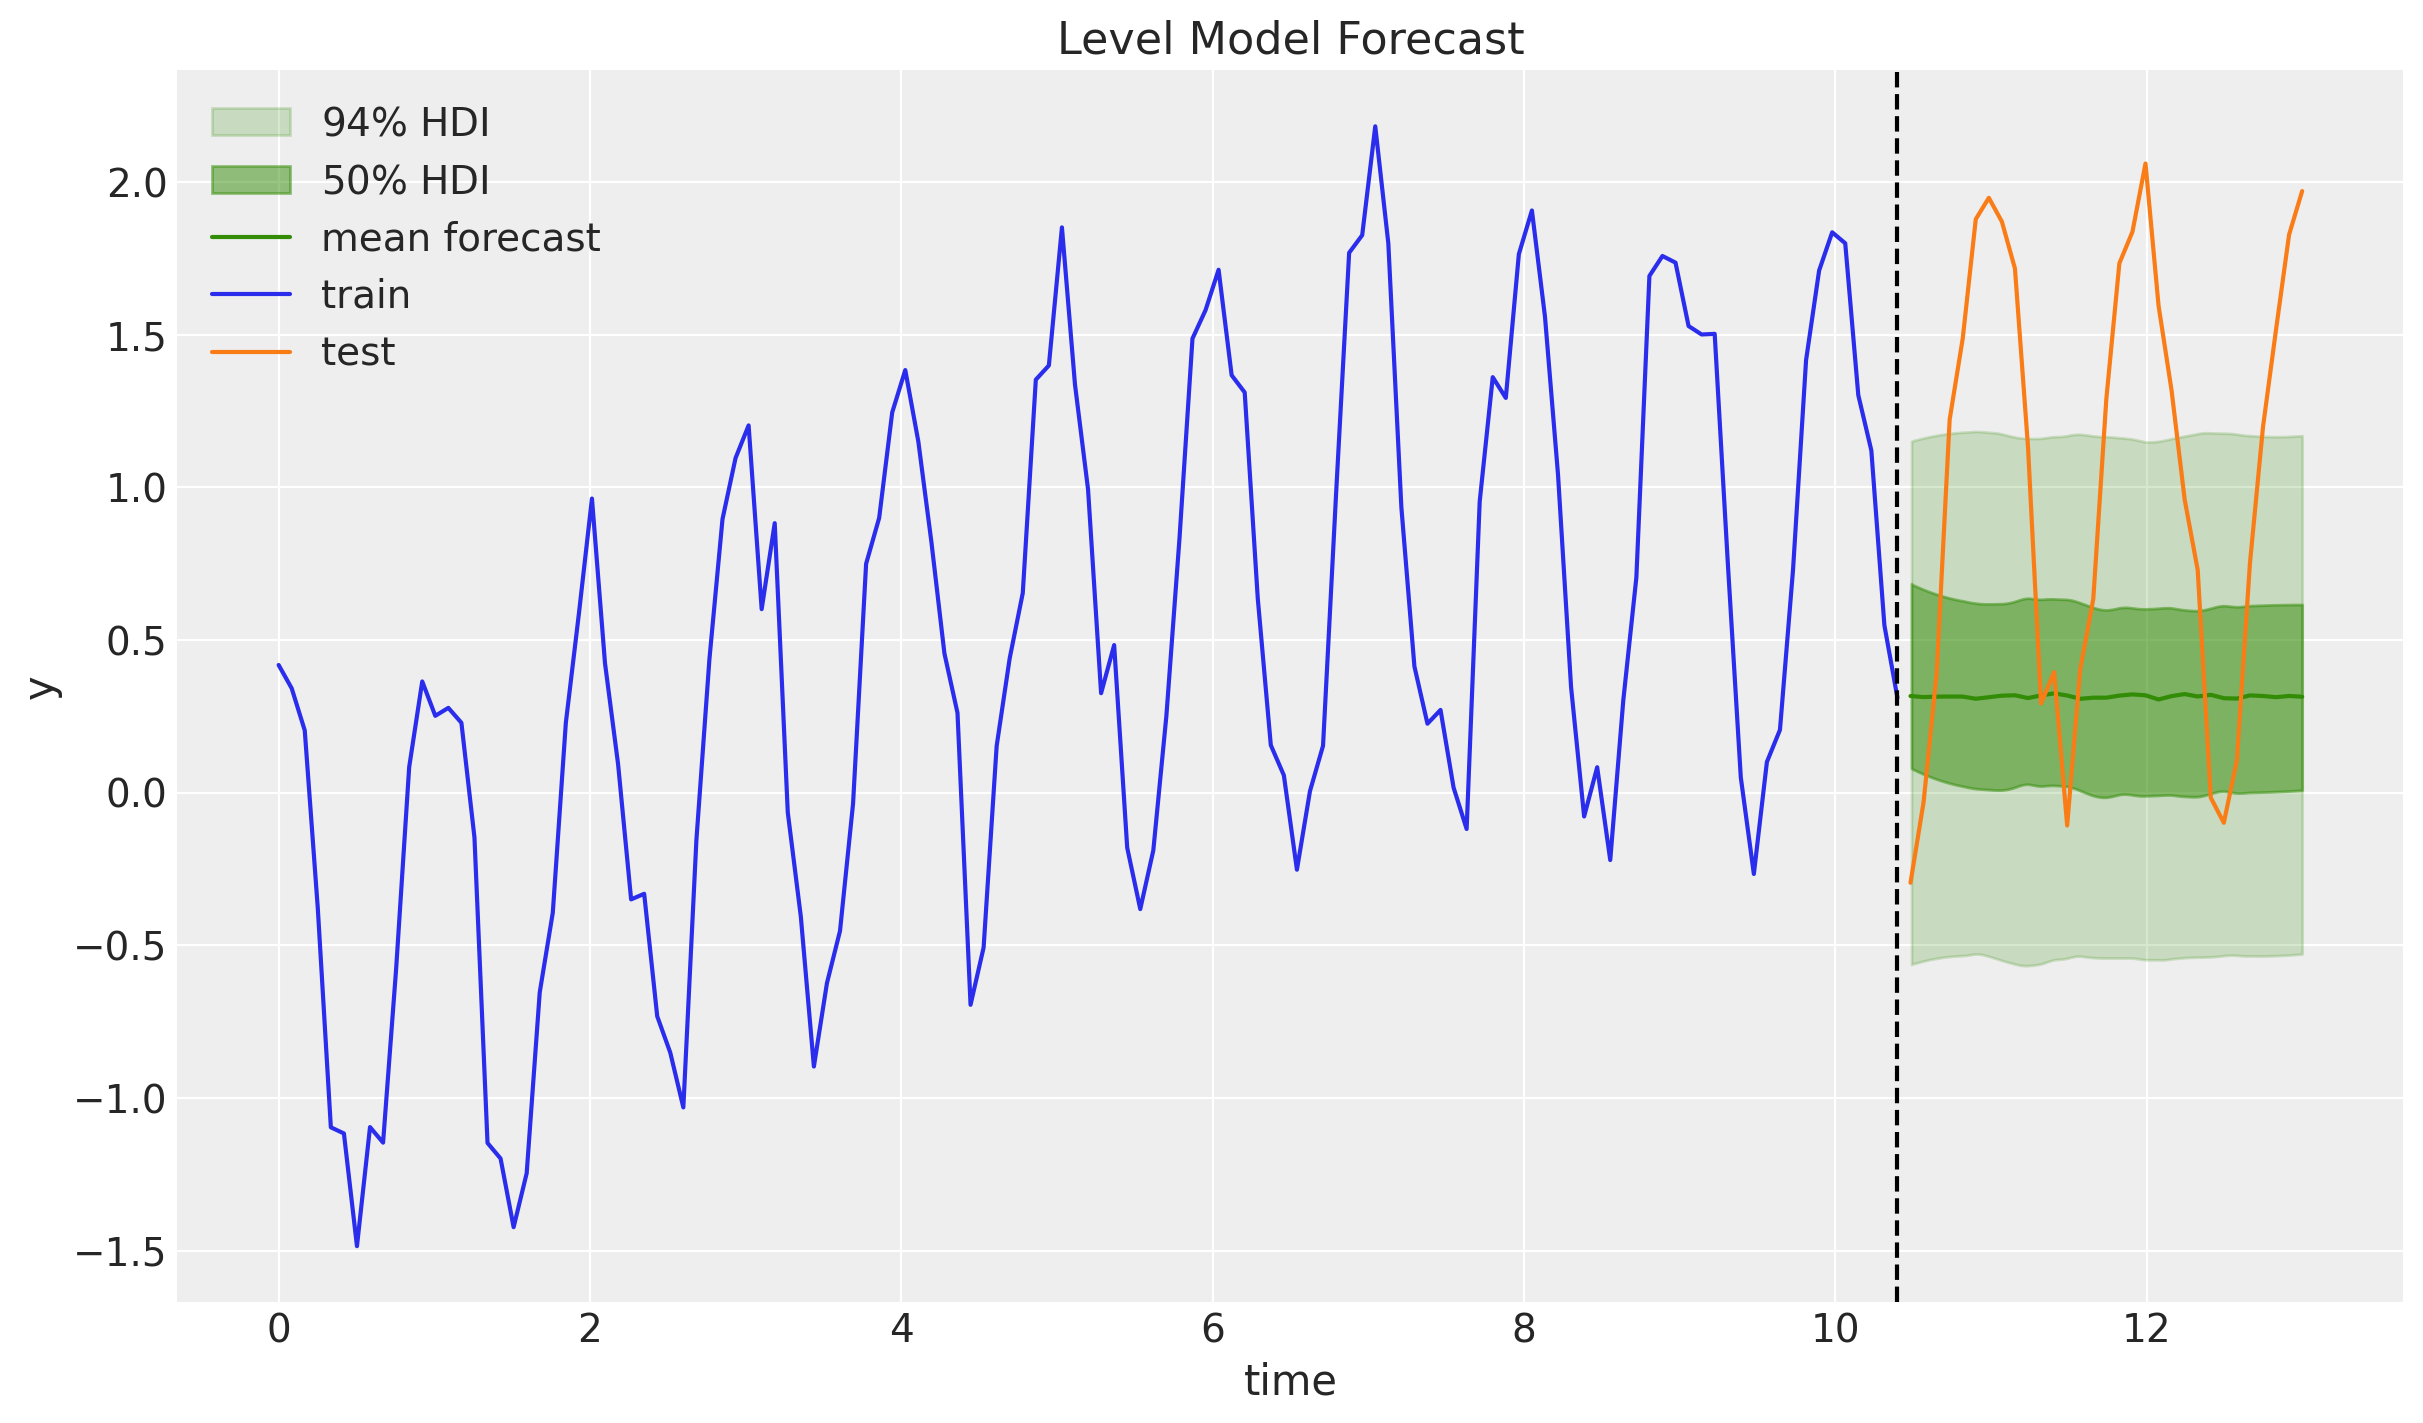

In [18]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=level_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    level_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level Model Forecast")

As expected, the forecast is flat.

## Level + Trend Model

Next, we add a trend component to the model. The trend model is defined by the following equations:

\begin{align*}
\hat{y}_{t+h|t} = & \: l_t + hb_t  \\
l_t = & \: \alpha y_t + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
b_t = & \: \beta^*(l_t - l_{t - 1}) + (1-\beta^*)b_{t - 1}
\end{align*}

Here $b_t$ denotes the trend at time $t$ and $\beta^*$ is a smoothing parameter. The trend equation is a weighted average of the difference between the current level and the previous level and the previous trend.

**Remark:** The reason for the upper $*$ in the $\beta^*$ is just a result of the notation in the context od the state space representation of the model. See [here](https://otexts.com/fpp3/ets.html#etsaan-holts-linear-method-with-additive-errors).

### Model Specification

Note that given the level model above, we can easily extend it to include the trend component:

In [28]:
def level_trend_model(y: ArrayImpl, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Trend
    trend_smoothing = numpyro.sample(
        "trend_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    trend_init = numpyro.sample("trend_init", dist.Normal(loc=0, scale=1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * y[t]
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        mu = previous_level + step * previous_trend
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        return (level, trend), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

We fit the model as before:

In [24]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_mcmc = run_inference(
    rng_subkey, level_trend_model, inference_params, y_train
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [25]:
level_trend_idata = az.from_numpyro(posterior=level_trend_mcmc)

az.summary(data=level_trend_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,0.450,0.400,-0.297,1.213,0.006,0.004,5163.0,4824.0,1.0
level_smoothing,0.886,0.061,0.789,0.999,0.001,0.001,4703.0,2978.0,1.0
noise,0.455,0.030,0.401,0.511,0.000,0.000,6010.0,5377.0,1.0
trend_init,-0.022,0.447,-0.844,0.817,0.006,0.005,5502.0,5177.0,1.0
trend_smoothing,0.820,0.119,0.615,1.000,0.002,0.001,4163.0,3771.0,1.0


In [26]:
print(f"""Divergences: {level_trend_idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Level + Trend Model Trace')

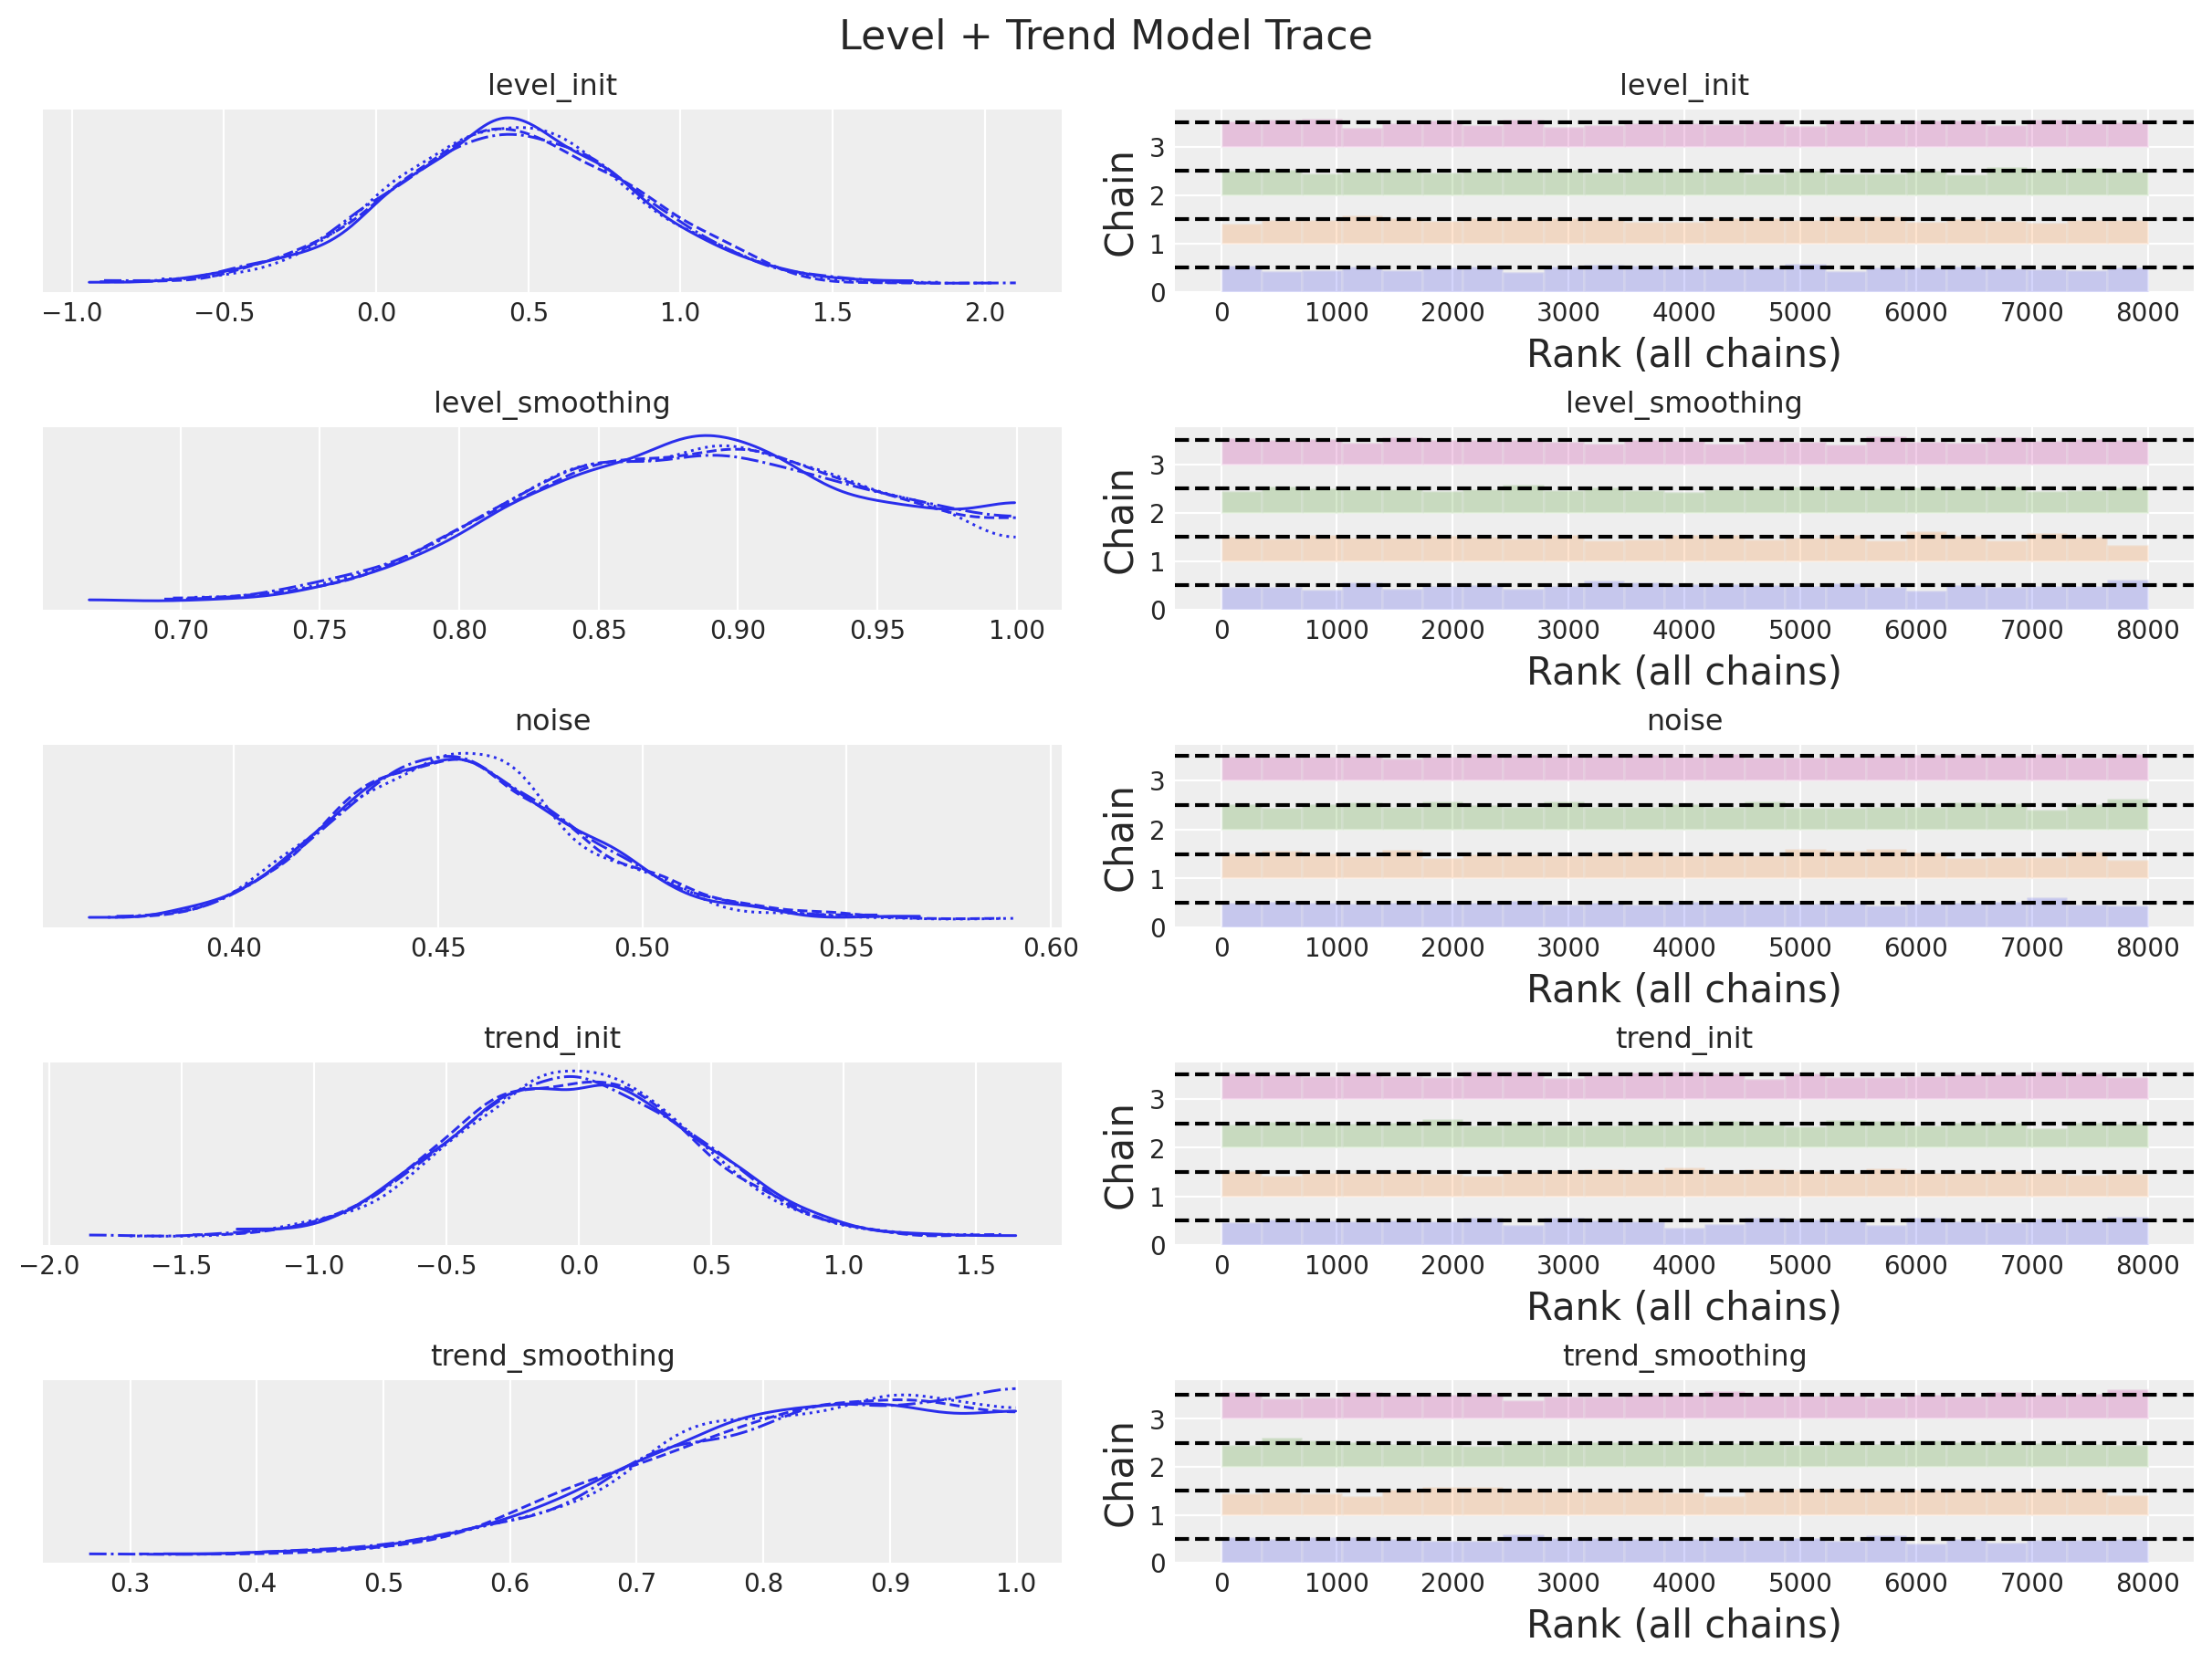

In [27]:
axes = az.plot_trace(
    data=level_trend_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Level + Trend Model Trace", fontsize=16)

### Forecast

We generate the forecast:

In [29]:
rng_key, rng_subkey = random.split(key=rng_key)
level_trend_forecast = forecast(
    rng_subkey, level_trend_model, level_trend_mcmc.get_samples(), y_train, y_test.size
)

level_trend_posterior_predictive = az.from_numpyro(
    posterior_predictive=level_trend_forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Level + Trend Model Forecast')]

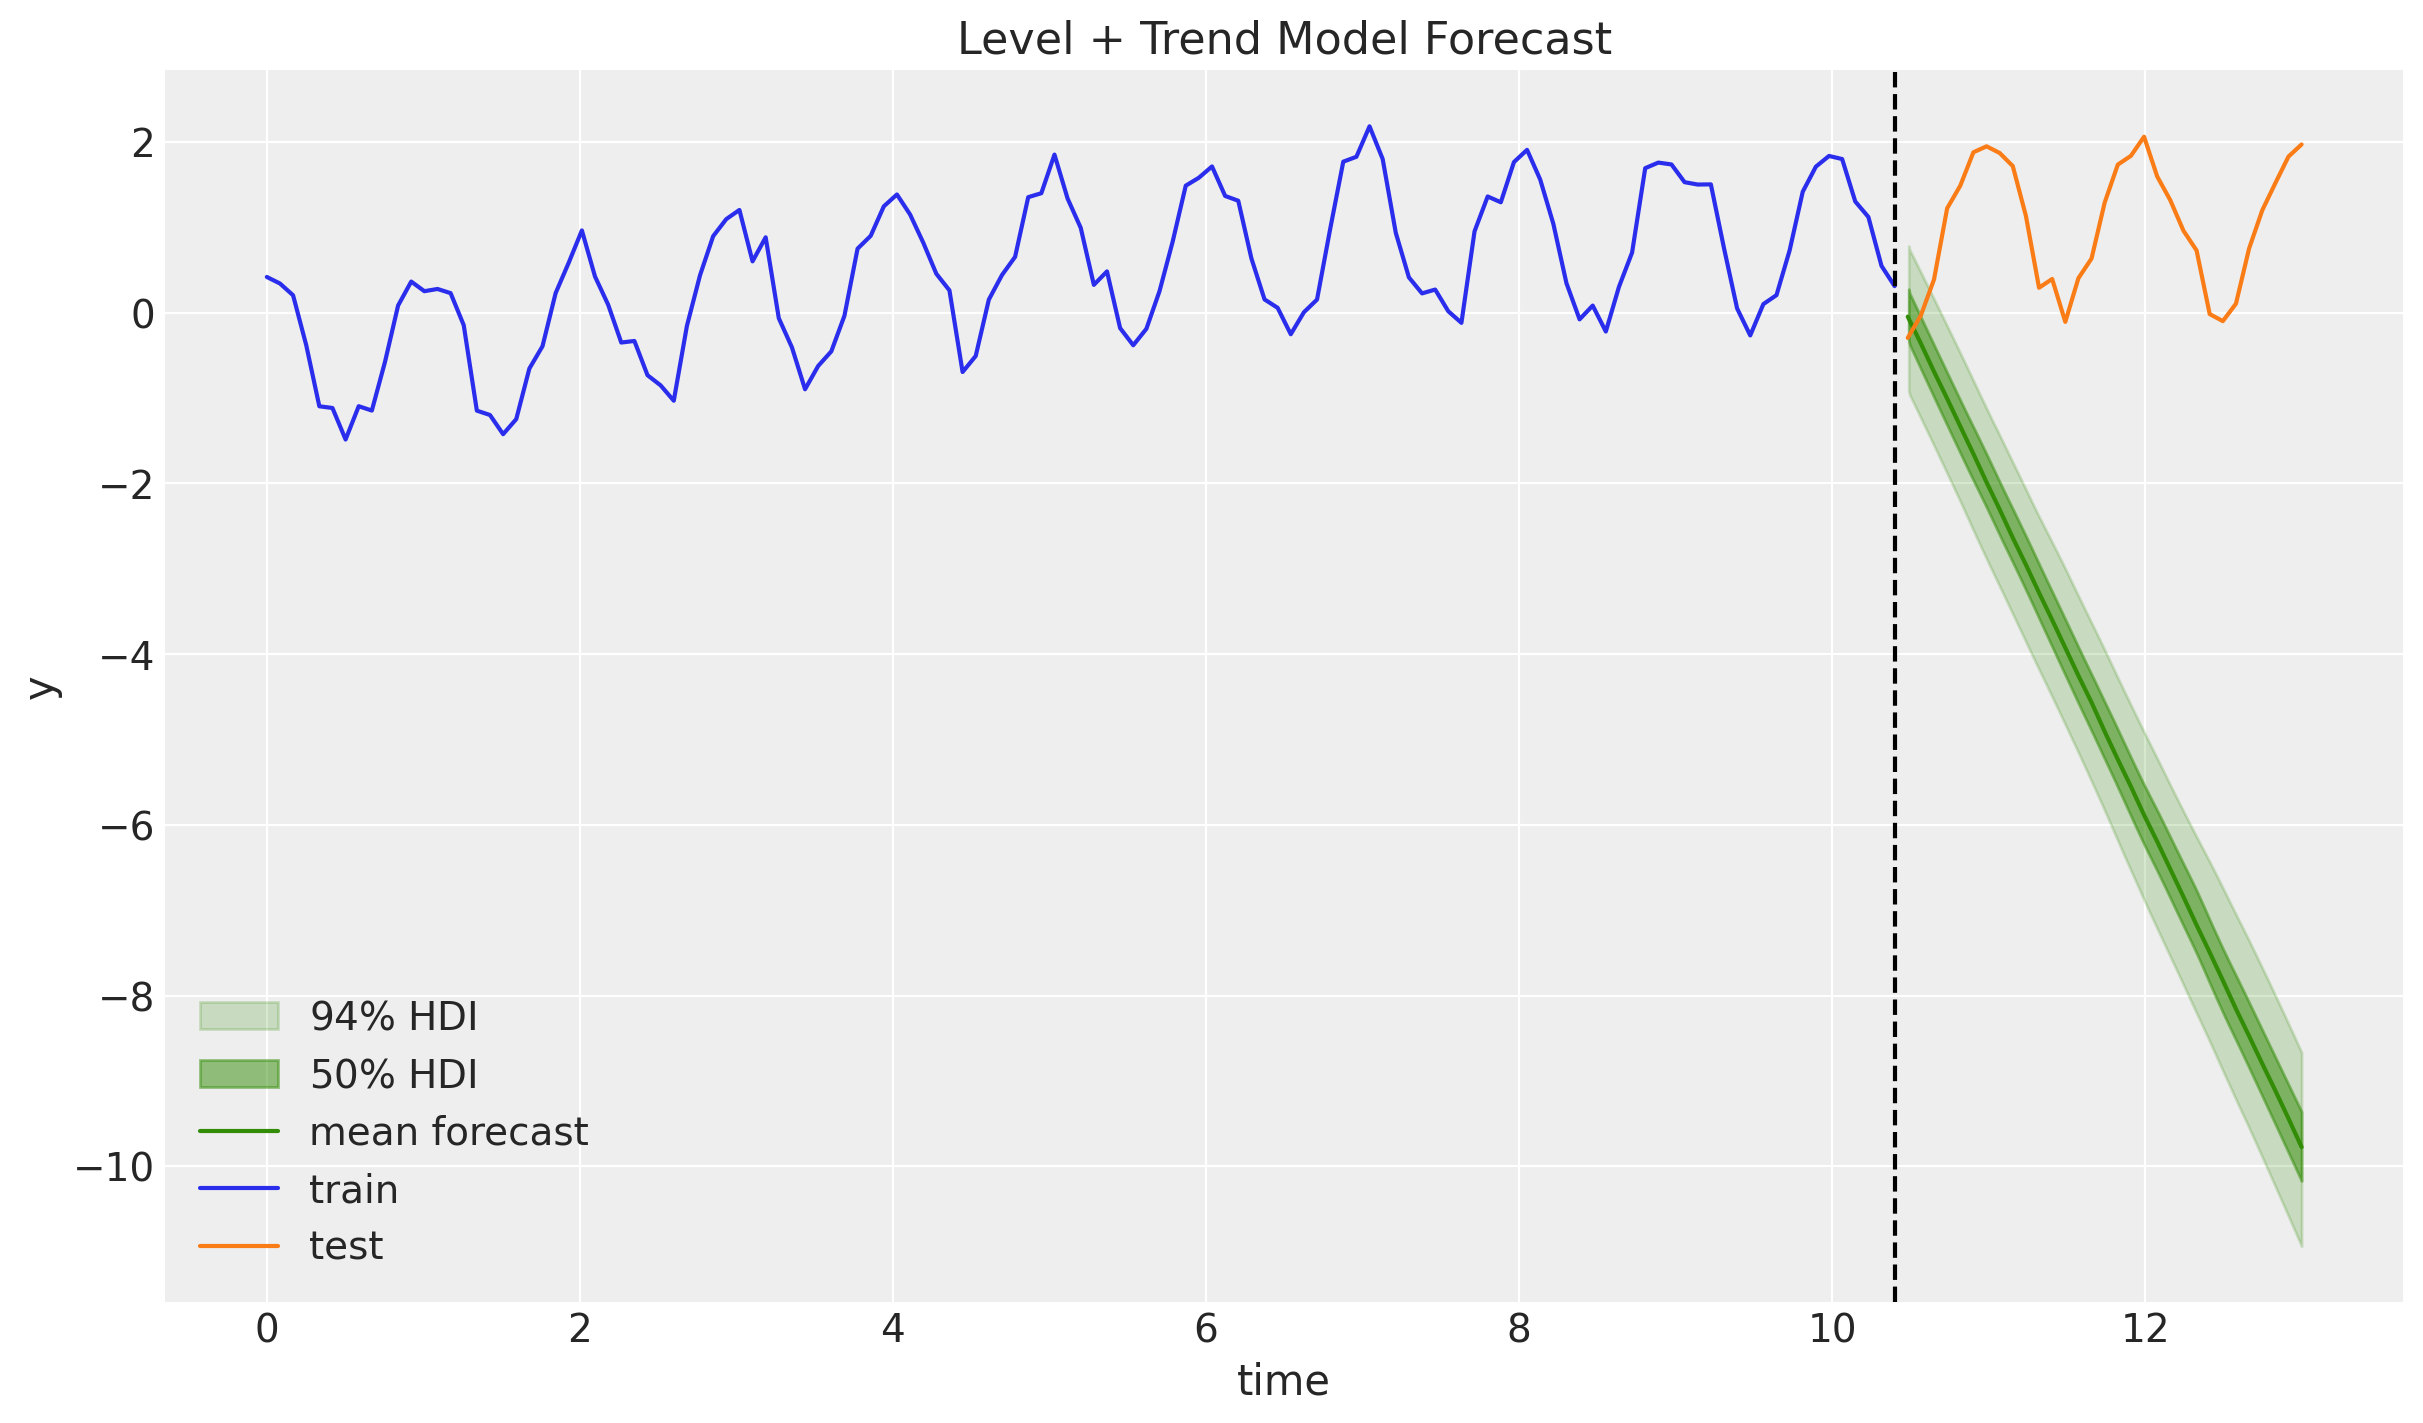

In [30]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=level_trend_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    level_trend_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Level + Trend Model Forecast")

Ups! This is literally just extrapolating with s straight line 😒. Still, this is often quite a good forecasting baseline for short term horizons. We are clearly missing the seasonality component to complement the trend model. This is what we do next!

## Level + Trend + Seasonality Model (Holt-Winters)

We have finally arrived at the (additive) level + trend + seasonality model, also known as Holt-Winters model. We extend the trend model to include a seasonal component:

\begin{align*}
\hat{y}_{t+h|t} = & \: l_t + hb_t + s_{t + h - m(k + 1)}  \\
l_t = & \: \alpha(y_t - s_{t - m}) + (1 - \alpha)(l_{t - 1} + b_{t - 1}) \\
b_t = & \:  \beta^*(l_t - l_{t - 1}) + (1 - \beta^*)b_{t - 1} \\
s_t = & \:  \gamma(y_t - l_{t - 1} - b_{t - 1})+(1 - \gamma)s_{t - m}
\end{align*}

We have added the seasonal component $s_t$ with the corresponding smoothing parameter $\gamma$. Here $m$ denotes the number of seasons. The parameter $k$ is the integer part of $(h - 1)/m$ (this just takes the latest seasonality estimate for this time point). for example, in the case $(h - 1)/m$ is an integer then

$$
t + h - m(k + 1) = t + h - m(h - 1)/m = t + h - (h - 1) = t + 1
$$

**Remark:** Similar to the note on thee $\beta^*$ notation, the parameter $\gamma$ is often called an adjusted smoothing as it is of the form $\gamma=\gamma^{*}(1 - \alpha)$, so that $0 \leq \gamma^{*} \leq 1$ translates to $0 \leq \gamma \leq 1 - \alpha$. This is just a result of the state space representation of the model. See [here](https://otexts.com/fpp3/holt-winters.html#holt-winters-additive-method).

### Model Specification

We now use the model from the example:

In [32]:
def holt_winters_model(y: ArrayImpl, n_seasons: int, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample(
        "level_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    level_init = numpyro.sample("level_init", dist.Normal(loc=0, scale=1))

    ## Trend
    trend_smoothing = numpyro.sample(
        "trend_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    trend_init = numpyro.sample("trend_init", dist.Normal(loc=0, scale=1))

    ## Seasonality
    seasonality_smoothing = numpyro.sample(
        "seasonality_smoothing", dist.Beta(concentration1=1, concentration0=1)
    )
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)

    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample(
            "seasonality_init", dist.Normal(loc=0, scale=1)
        )

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * previous_trend,
            previous_trend,
        )

        new_season = jnp.where(
            t < t_max,
            adj_seasonality_smoothing * (y[t] - (previous_level + previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)

        mu = previous_level + step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(loc=mu, scale=noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )

        return (level, trend, seasonality), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [33]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_mcmc = run_inference(
    rng_subkey,
    holt_winters_model,
    inference_params,
    y_train,
    n_seasons,
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [34]:
holt_winters_idata = az.from_numpyro(posterior=holt_winters_mcmc)

az.summary(data=holt_winters_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
level_init,-0.437,0.302,-1.030,0.104,0.009,0.006,1217.0,2202.0,1.0
level_smoothing,0.128,0.066,0.014,0.239,0.001,0.001,2461.0,2565.0,1.0
noise,0.255,0.018,0.222,0.288,0.000,0.000,3606.0,4307.0,1.0
seasonality_init[0],0.837,0.318,0.248,1.431,0.009,0.006,1344.0,2441.0,1.0
seasonality_init[1],0.594,0.316,0.023,1.196,0.009,0.006,1367.0,2501.0,1.0
seasonality_init[2],0.437,0.317,-0.137,1.062,0.009,0.006,1255.0,2197.0,1.0
seasonality_init[3],-0.099,0.321,-0.670,0.530,0.009,0.006,1322.0,2596.0,1.0
seasonality_init[4],-0.594,0.313,-1.201,-0.029,0.009,0.006,1312.0,2438.0,1.0
seasonality_init[5],-0.830,0.317,-1.429,-0.238,0.009,0.006,1335.0,2604.0,1.0
seasonality_init[6],-1.001,0.318,-1.600,-0.403,0.009,0.006,1308.0,2291.0,1.0


In [35]:
print(
    f"""Divergences: {holt_winters_idata["sample_stats"]["diverging"].sum().item()}"""
)

Divergences: 0


Text(0.5, 0.98, 'Holt Winters Trace')

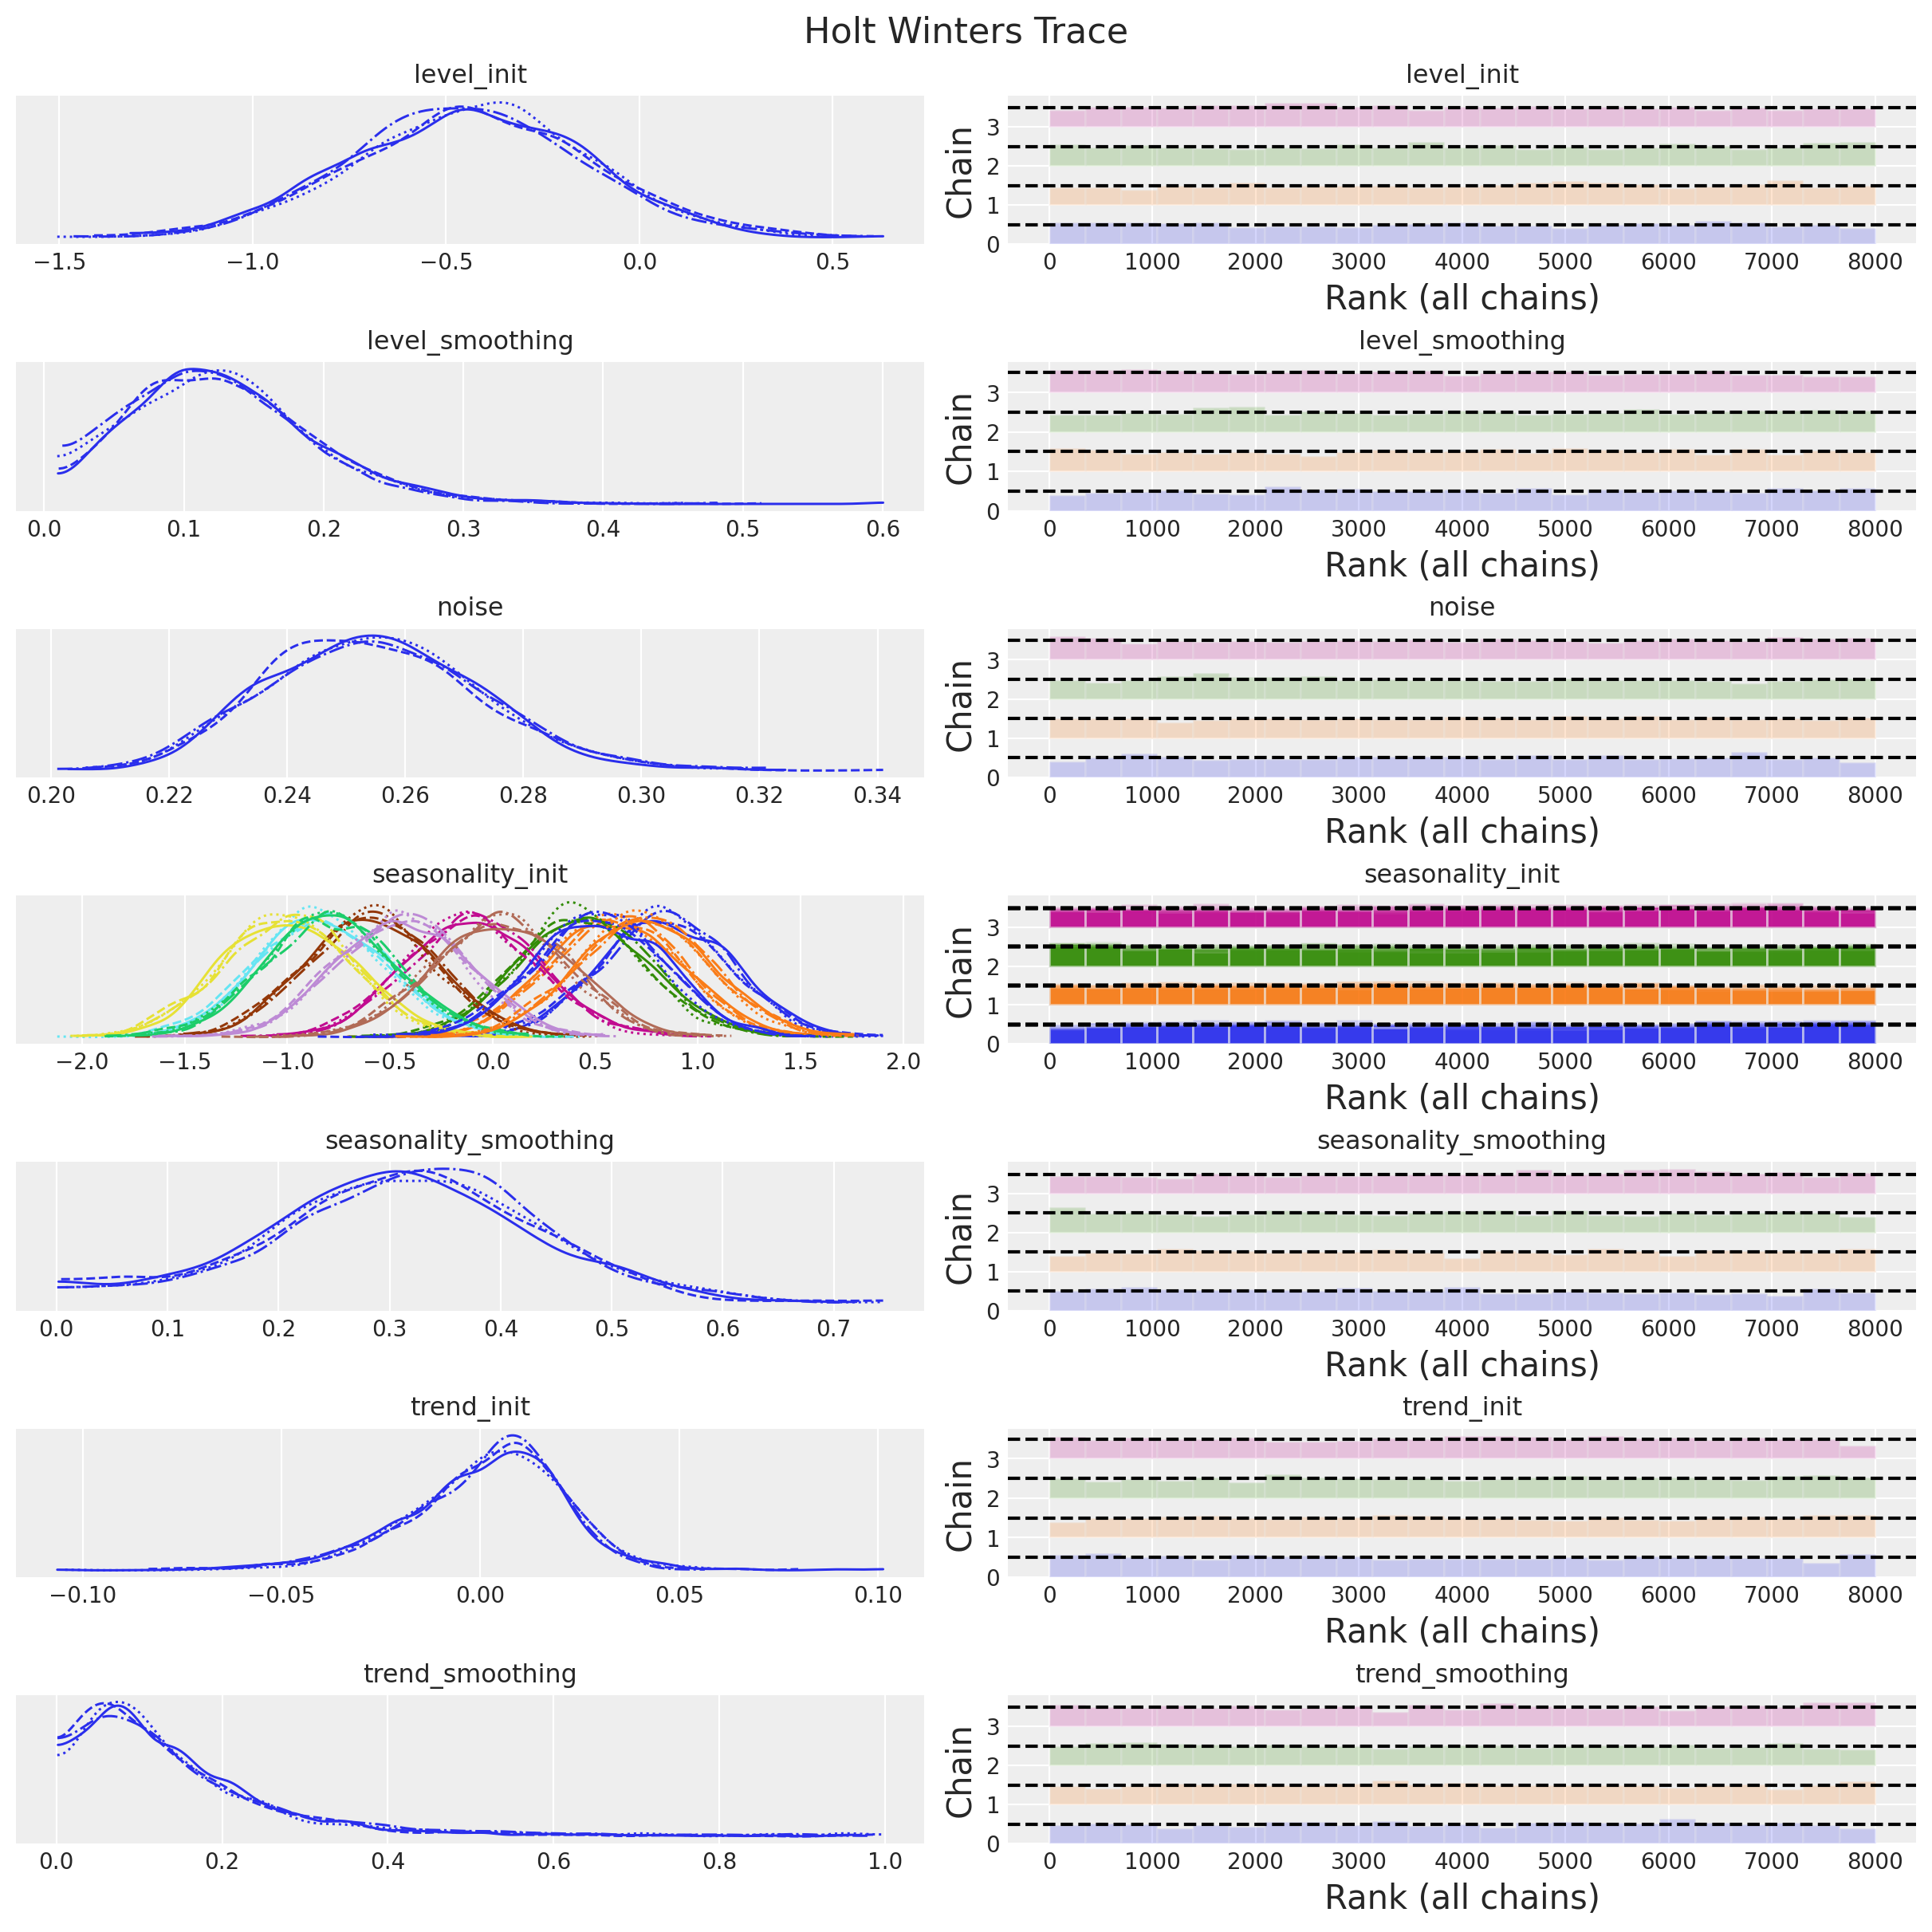

In [36]:
axes = az.plot_trace(
    data=holt_winters_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Holt Winters Trace", fontsize=16)

### Forecast

In [37]:
rng_key, rng_subkey = random.split(key=rng_key)
holt_winters_forecast = forecast(
    rng_subkey,
    holt_winters_model,
    holt_winters_mcmc.get_samples(),
    y_train,
    n_seasons,
    y_test.size,
)

holt_winters_posterior_predictive = az.from_numpyro(
    posterior_predictive=holt_winters_forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Holt Winters Model Forecast')]

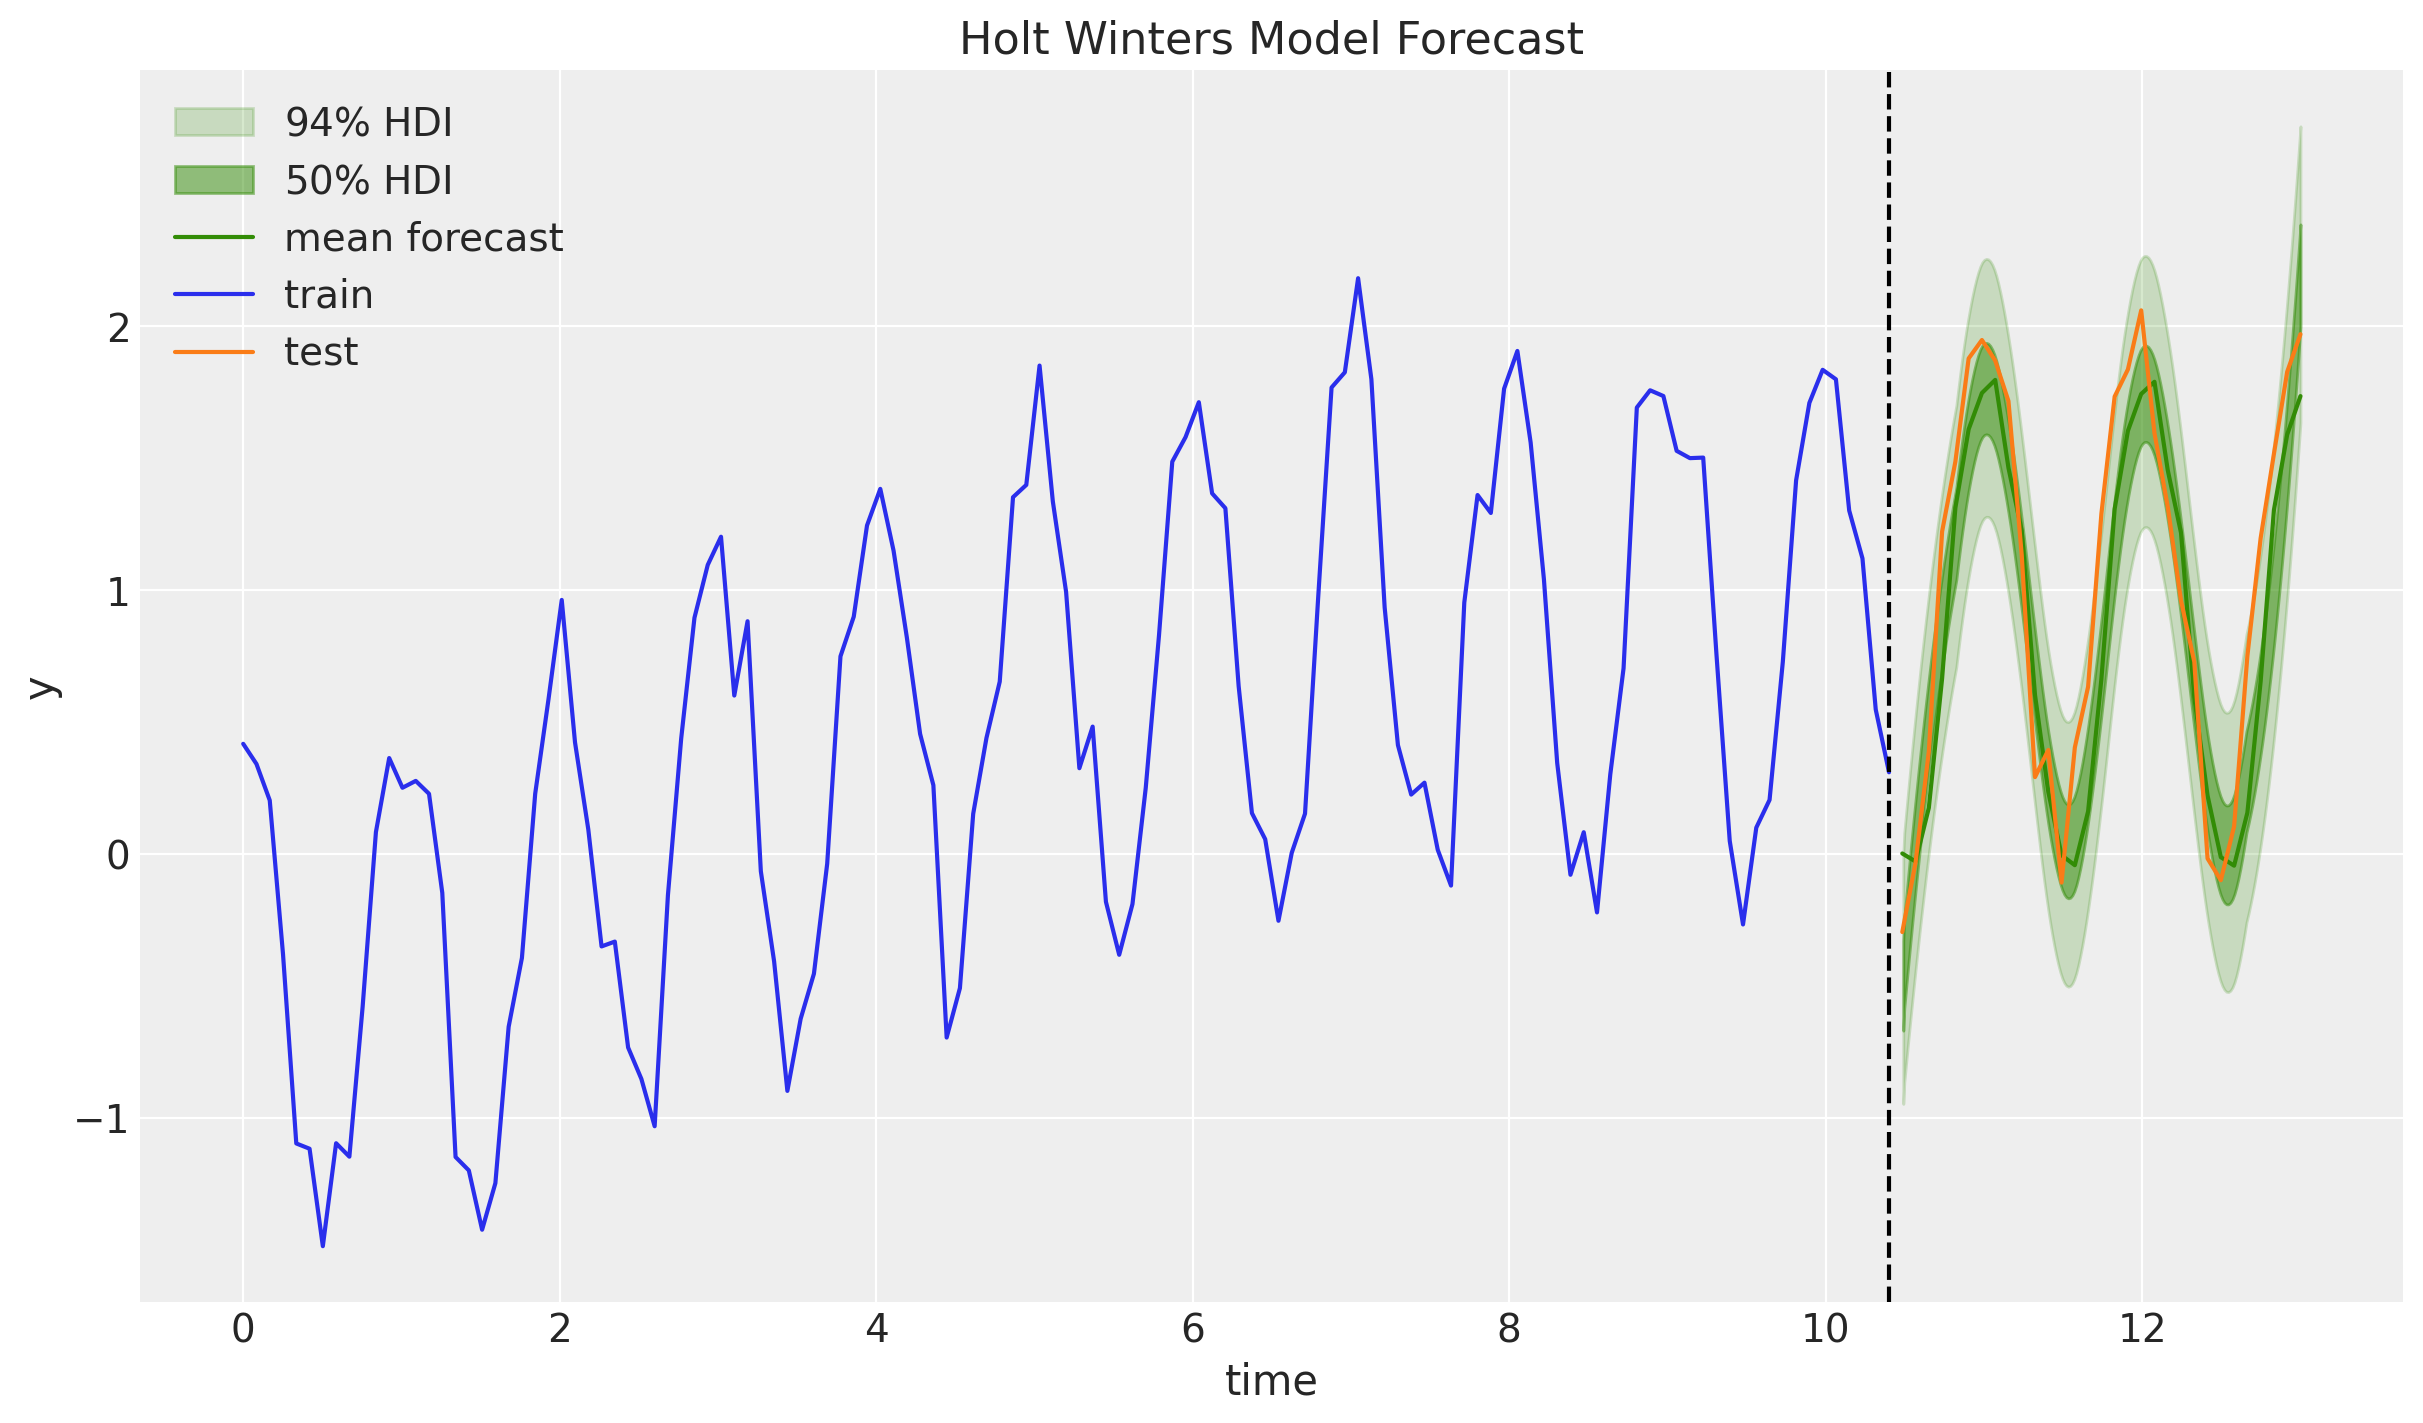

In [38]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Holt Winters Model Forecast")

## Damped Holt-Winters

### Model Specification

In [ ]:
def sum_of_powers(x, n):
    def transition_fn(carry, x):
        power_sum, power = carry
        power = power * x
        power_sum = power_sum + power
        return (power_sum, power), power_sum

    (power_sum, _), _ = scan(f=transition_fn, init=(0, 1), xs=jnp.ones(n) * x)
    return power_sum


# Example usage
x = 2  # p
n = jnp.array(3)
sum_of_powers(x, 2)

In [ ]:
import preliz as pz

pz.Beta(alpha=2, beta=5).plot_pdf()

In [ ]:
def damped_holt_winters_model(y: ArrayImpl, n_seasons: int, future: int = 0) -> None:
    # Get time series length
    t_max = y.shape[0]

    # --- Priors ---

    ## Level
    level_smoothing = numpyro.sample("level_smoothing", dist.Beta(2, 2))
    level_init = numpyro.sample("level_init", dist.Normal(0, 1))

    ## Trend
    trend_smoothing = numpyro.sample("trend_smoothing", dist.Beta(2, 2))
    trend_init = numpyro.sample("trend_init", dist.Normal(0.5, 1))

    ## Seasonality
    seasonality_smoothing = numpyro.sample("seasonality_smoothing", dist.Beta(2, 2))
    adj_seasonality_smoothing = seasonality_smoothing * (1 - level_smoothing)

    ## Damping
    phi = numpyro.sample("phi", dist.Beta(2, 5))

    with numpyro.plate("n_seasons", n_seasons):
        seasonality_init = numpyro.sample("seasonality_init", dist.Normal(0, 1))

    ## Noise
    noise = numpyro.sample("noise", dist.HalfNormal(1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        previous_level, previous_trend, previous_seasonality = carry

        level = jnp.where(
            t < t_max,
            level_smoothing * (y[t] - previous_seasonality[0])
            + (1 - level_smoothing) * (previous_level + phi * previous_trend),
            previous_level,
        )

        trend = jnp.where(
            t < t_max,
            trend_smoothing * (level - previous_level)
            + (1 - trend_smoothing) * phi * previous_trend,
            previous_trend,
        )

        new_season = jnp.where(
            t < t_max,
            adj_seasonality_smoothing * (y[t] - (previous_level + phi * previous_trend))
            + (1 - adj_seasonality_smoothing) * previous_seasonality[0],
            previous_seasonality[0],
        )

        step = jnp.where(t < t_max, 1, t - t_max + 1)
        phi_step = fori_loop(
            lower=1, upper=step + 1, body_fun=lambda i, val: val + phi**i, init_val=0
        )

        mu = previous_level + phi_step * previous_trend + previous_seasonality[0]
        pred = numpyro.sample("pred", dist.Normal(mu, noise))

        seasonality = jnp.concatenate(
            [previous_seasonality[1:], new_season[None]], axis=0
        )

        return (level, trend, seasonality), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": y}):
        _, preds = scan(
            transition_fn,
            (level_init, trend_init, seasonality_init),
            jnp.arange(t_max + future),
        )

    # --- Forecast ---
    if future > 0:
        numpyro.deterministic("y_forecast", preds[-future:])

### Inference

In [ ]:
from jax.lax import fori_loop

x = 2
n = 2

fori_loop(lower=1, upper=n + 1, body_fun=lambda i, val: val + x**i, init_val=0)

In [ ]:
phi = 2
step = 3
jnp.array([phi**j for j in range(1, step + 1)]).sum()

In [ ]:
rng_key, rng_subkey = random.split(key=rng_key)
damped_holt_winters_mcmc = run_inference(
    rng_subkey,
    damped_holt_winters_model,
    inference_params,
    y_train,
    n_seasons,
    target_accept_prob=0.95,
    forward_mode_differentiation=True,
)

In [ ]:
damped_holt_winters_idata = az.from_numpyro(posterior=damped_holt_winters_mcmc)

az.summary(data=damped_holt_winters_idata)

In [ ]:
print(
    f"""Divergences: {damped_holt_winters_idata["sample_stats"]["diverging"].sum().item()}"""
)

In [ ]:
axes = az.plot_trace(
    data=damped_holt_winters_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 12), "layout": "constrained"},
)
plt.gcf().suptitle("Holt Winters Trace", fontsize=16)

### Forecast

In [ ]:
rng_key, rng_subkey = random.split(key=rng_key)
damped_holt_winters_forecast = forecast(
    rng_subkey,
    damped_holt_winters_model,
    holt_winters_mcmc.get_samples(),
    y_train,
    n_seasons,
    y_test.size,
)

damped_holt_winters_posterior_predictive = az.from_numpyro(
    posterior_predictive=damped_holt_winters_forecast,
    coords={"t": t_test},
    dims={"y_forecast": ["t"]},
)

In [ ]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=damped_holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=damped_holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C2",
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    damped_holt_winters_posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C2",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Damped Holt Winters Model Forecast")